# Load packages and set work dir

In [1]:
def date(string):
    string2 = str(string)
    if len(string2)<6:
        a= 0
    else:
        a= 1
    return a    

def split(string):
    try:
        date_time_str = string.split(" ")[0]
    except:
        date_time_str = ''
    return date_time_str 

def naTyear(string):
    if type(string) == pd._libs.tslibs.nattype.NaTType:
        a = 0
    else:
        a = 1
    return a

def year(date):
    month = date.month
    day = date.day
    
    if (month == 1)&(day == 1):
        year = date.year
    else:
        year = date
    return year

def get_year(date):
    year = date.year
    return year


def tojulian(string):
    try:
        dt = string.split('/')
        dt2 = datetime(int(dt[2]), int(dt[0]), int(dt[1]))
        ju_dt = dt2.strftime('%j')
        return(ju_dt)
    except:
        return None
    
def tojulian(string):
    
    try:
        if len(string)>4:
            try:
                dt = string.split('/')
                dt2 = datetime(int(dt[2]), int(dt[0]), int(dt[1]))
                ju_dt = dt2.strftime('%j')
                return(ju_dt)

            except:
                return string
        else:
            return string
    except:
        return string
    
def str2nb(str0):
    
    try:
        str0b = str0[1:-1]
        nb = float(str0b)
    except:
        nb = str0
        
    return nb

In [2]:
from scipy.stats.stats import pearsonr
from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import StandardScaler
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
import pyxlsb
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids
from kneed import KneeLocator
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
import warnings
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression as LR
from  sklearn.cluster import AgglomerativeClustering 
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
#os.chdir('C:/Users/s1052014/OneDrive - Syngenta/Desktop/GE/GS_corn/GS/DL')

# Data-driven clustering function for YGSMN

## No variable selection no weight 

In [4]:
def var_imp_cluster_nvs_nwt(dt_x, dt_y, n_cluster=3):
   
    clusters_df1 = pd.DataFrame()
    sse_ls1 = []
    for rp in range(10):
        kmns = KMeans(n_clusters=n_cluster, n_init=15, max_iter=500, init='k-means++')
        kmns.fit(dt_x)

        lb = kmns.labels_
        lb_df = pd.DataFrame(lb)
        clusters_df1 = pd.concat([clusters_df1, lb_df], axis=1)

        sses = kmns.inertia_
        sse_ls1.append(sses)

    sse_df1 = pd.DataFrame(sse_ls1)
    ind1 = sse_df1[0].argmin(axis=0)
    clusters= clusters_df1.iloc[:,ind1]
    return(clusters)

## Variable selection but no weights 

In [5]:
def var_imp_cluster_nwt(dt_x, dt_y, n_cluster=3):
    nvar = dt_x.shape[1]
    r2A = []
    psA= []
    for i in range(nvar):
        
        fac_x2 = PolynomialFeatures(degree=1).fit_transform(dt_x.iloc[:,i].to_numpy().reshape(-1,1))
        r2s = []
        ps = []
        for k in range(10):
            fea_tr, fea_ts, y_tr, y_ts = train_test_split(fac_x2, dt_y, test_size=0.2, random_state = k*1000)
            lrm = LR().fit(fea_tr, y_tr)
            lr_pred = lrm.predict(fea_ts)

           # r2= sklearn.metrics.r2_score(y_ts, lr_pred)
            fea_pred= pd.DataFrame(lr_pred)
            fea_pred.index = y_ts.index
            fea_pred['ygsmn']= y_ts
            r2=  pearsonr(lr_pred.ravel(), y_ts['yield_gap'])[0]
            r2s.append(r2)
            p=  pearsonr(lr_pred.ravel(), y_ts['yield_gap'])[1]
            ps.append(p)
            
        mn = pd.DataFrame(r2s).median()    
        r2A.append(mn) 
        pm = pd.DataFrame(ps).median()    
        psA.append(pm) 
        
    r2A = pd.DataFrame(r2A).round(4)
    psA = pd.DataFrame(psA).round(4)
    r2A.rename(columns={0:'Coefficient'}, inplace=True)
    r2A['Coefficient'] = 1
    r2A['Coefficient'].loc[psA[0]>0.05]  = 0
    
    for i in range(nvar):
        dt_x.iloc[:,i] = dt_x.iloc[:,i]*r2A['Coefficient'][i]
    
    clusters_df1 = pd.DataFrame()
    sse_ls1 = []
    for rp in range(10):
        kmns = KMeans(n_clusters=n_cluster, n_init=15, max_iter=500, init='k-means++')
        kmns.fit(dt_x)

        lb = kmns.labels_
        lb_df = pd.DataFrame(lb)
        clusters_df1 = pd.concat([clusters_df1, lb_df], axis=1)

        sses = kmns.inertia_
        sse_ls1.append(sses)

    sse_df1 = pd.DataFrame(sse_ls1)
    ind1 = sse_df1[0].argmin(axis=0)
    clusters= clusters_df1.iloc[:,ind1]
    return(clusters)

## K-means

### Linear model 

In [4]:
from scipy.stats.stats import pearsonr

In [358]:
def var_imp_cluster_li(dt_x, dt_y, n_cluster=3):
    nvar = dt_x.shape[1]
    r2A = []
    psA= []
    for i in range(nvar):
        
        fac_x2 = PolynomialFeatures(degree=1).fit_transform(dt_x.iloc[:,i].to_numpy().reshape(-1,1))
        r2s = []
        ps = []
        for k in range(20):
            fea_tr, fea_ts, y_tr, y_ts = train_test_split(fac_x2, dt_y, test_size=0.2, random_state = k*1000)
            lrm = LR().fit(fea_tr, y_tr)
            lr_pred = lrm.predict(fea_ts)

           # r2= sklearn.metrics.r2_score(y_ts, lr_pred)
            fea_pred= pd.DataFrame(lr_pred)
            fea_pred.index = y_ts.index
            fea_pred['ygsmn']= y_ts
            r2=  pearsonr(lr_pred.ravel(), y_ts['yield_gap'])[0]
            r2s.append(r2)
            p=  pearsonr(lr_pred.ravel(), y_ts['yield_gap'])[1]
            ps.append(p)
            
        mn = pd.DataFrame(r2s).median()    
        r2A.append(mn) 
        pm = pd.DataFrame(ps).median()    
        psA.append(pm) 
        
    r2A = pd.DataFrame(r2A).round(4)
    psA = pd.DataFrame(psA).round(4)
    r2A.rename(columns={0:'Coefficient'}, inplace=True)
    r2A['Coefficient'].loc[psA[0]>0.05]  = 0
    #r2A['Coefficient'] = np.sqrt(r2A['Coefficient'])
    
    for i in range(nvar):
        dt_x.iloc[:,i] = dt_x.iloc[:,i]*r2A['Coefficient'][i]
    
    clusters_df1 = pd.DataFrame()
    sse_ls1 = []
    for rp in range(10):
        kmns = KMeans(n_clusters=n_cluster, n_init=15, max_iter=500, init='k-means++')
        kmns.fit(dt_x)

        lb = kmns.labels_
        lb_df = pd.DataFrame(lb)
        clusters_df1 = pd.concat([clusters_df1, lb_df], axis=1)

        sses = kmns.inertia_
        sse_ls1.append(sses)

    sse_df1 = pd.DataFrame(sse_ls1)
    ind1 = sse_df1[0].argmin(axis=0)
    clusters= clusters_df1.iloc[:,ind1]
    return(clusters)

### RF Model 

In [ ]:
def var_imp_cluster_rf(dt_x, dt_y, n_cluster=3):

    nvar = dt_x.shape[1]

    psA= []
    for i in range(nvar):

        fac_x2 = PolynomialFeatures(degree=1).fit_transform(dt_x.iloc[:,i].to_numpy().reshape(-1,1))
        r2s = []
        ps = []
        for k in range(20):
            fea_tr, fea_ts, y_tr, y_ts = train_test_split(fac_x2, dt_y, test_size=0.2, random_state = k*1000)
            lrm = LR().fit(fea_tr, y_tr)
            lr_pred = lrm.predict(fea_ts)

           # r2= sklearn.metrics.r2_score(y_ts, lr_pred)
            fea_pred= pd.DataFrame(lr_pred)
            fea_pred.index = y_ts.index
            fea_pred['ygsmn']= y_ts
            r2=  pearsonr(lr_pred.ravel(), y_ts['yield_gap'])[0]
            r2s.append(r2)
            p=  pearsonr(lr_pred.ravel(), y_ts['yield_gap'])[1]
            ps.append(p)

        mn = pd.DataFrame(r2s).median()
        pm = pd.DataFrame(ps).median()
        psA.append(pm)

    psA = pd.DataFrame(psA).round(3)
    
    dt_x = dt_x.loc[:,((psA[0]<0.05)|(psA[0]==0.05))]

    rf = RandomForestRegressor(n_estimators=100, n_jobs=6)
    rf.fit(dt_x, dt_y)
    r2A = rf.feature_importances_
    r2A = pd.DataFrame(r2A).round(3)
    r2A.rename(columns={0:'Coefficient'}, inplace=True)
    #r2A['Coefficient'].loc[psA[0]>0.05]  = 0
    nvar = dt_x.shape[1]

    for i in range(nvar):
        dt_x.iloc[:,i] = dt_x.iloc[:,i]*r2A['Coefficient'][i]


    clusters_df1 = pd.DataFrame()
    sse_ls1 = []
    for rp in range(50):
        kmns = KMeans(n_clusters=n_cluster, n_init=20, max_iter=500, init='k-means++')
        kmns.fit(dt_x)

        lb = kmns.labels_
        lb_df = pd.DataFrame(lb)
        clusters_df1 = pd.concat([clusters_df1, lb_df], axis=1)

        sses = kmns.inertia_
        sse_ls1.append(sses)

    sse_df1 = pd.DataFrame(sse_ls1)
    ind1 = sse_df1[0].argmin(axis=0)
    clusters= clusters_df1.iloc[:,ind1]
    return(clusters)

## Hierachical 

### Linear model 

In [6]:
def var_imp_cluster_li(dt_x, dt_y, n_cluster=3):
    nvar = dt_x.shape[1]
    r2A = []
    psA= []
    for i in range(nvar):
        
        fac_x2 = PolynomialFeatures(degree=1).fit_transform(dt_x.iloc[:,i].to_numpy().reshape(-1,1))
        r2s = []
        ps = []
        for k in range(20):
            fea_tr, fea_ts, y_tr, y_ts = train_test_split(fac_x2, dt_y, test_size=0.25, random_state = k*1000)
            lrm = LR().fit(fea_tr, y_tr)
            lr_pred = lrm.predict(fea_ts)

           # r2= sklearn.metrics.r2_score(y_ts, lr_pred)
            fea_pred= pd.DataFrame(lr_pred)
            fea_pred.index = y_ts.index
            fea_pred['ygsmn']= y_ts
            r2=  pearsonr(lr_pred.ravel(), y_ts['yield_gap'])[0]
            r2s.append(r2)
            p=  pearsonr(lr_pred.ravel(), y_ts['yield_gap'])[1]
            ps.append(p)
            
        mn = pd.DataFrame(r2s).median()    
        r2A.append(mn) 
        pm = pd.DataFrame(ps).median()    
        psA.append(pm) 
        
    r2A = pd.DataFrame(r2A).round(4)
    psA = pd.DataFrame(psA).round(4)
    r2A.rename(columns={0:'Coefficient'}, inplace=True)
    r2A['Coefficient'].loc[psA[0]>0.05]  = 0
    #r2A['Coefficient'] = np.sqrt(r2A['Coefficient'])
    
    for i in range(nvar):
        dt_x.iloc[:,i] = dt_x.iloc[:,i]*r2A['Coefficient'][i]
    
    clusters_df1 = pd.DataFrame()
    sse_ls1 = []
    for i in range(nvar):
        dt_x.iloc[:,i] = dt_x.iloc[:,i]*r2A['Coefficient'][i]


    clusters_df1 = pd.DataFrame()
    sse_ls1 = []
    for rp in range(1):
        kmns = AgglomerativeClustering(n_clusters= n_cluster)
        kmns.fit(dt_x)

        lb = kmns.labels_
        lb_df = pd.DataFrame(lb)
        
    clusters= lb_df
    return(clusters)

### Random forest

In [7]:
def var_imp_cluster_rf(dt_x, dt_y, n_cluster=3):

    nvar = dt_x.shape[1]

    psA= []
    for i in range(nvar):

        fac_x2 = PolynomialFeatures(degree=1).fit_transform(dt_x.iloc[:,i].to_numpy().reshape(-1,1))
        r2s = []
        ps = []
        for k in range(20):
            fea_tr, fea_ts, y_tr, y_ts = train_test_split(fac_x2, dt_y, test_size=0.25, random_state = k*1000)
            lrm = LR().fit(fea_tr, y_tr)
            lr_pred = lrm.predict(fea_ts)

           # r2= sklearn.metrics.r2_score(y_ts, lr_pred)
            fea_pred= pd.DataFrame(lr_pred)
            fea_pred.index = y_ts.index
            fea_pred['ygsmn']= y_ts
            r2=  pearsonr(lr_pred.ravel(), y_ts['yield_gap'])[0]
            r2s.append(r2)
            p=  pearsonr(lr_pred.ravel(), y_ts['yield_gap'])[1]
            ps.append(p)

        mn = pd.DataFrame(r2s).median()
        pm = pd.DataFrame(ps).median()
        psA.append(pm)

    psA = pd.DataFrame(psA).round(3)
    
    dt_x = dt_x.loc[:,((psA[0]<0.05)|(psA[0]==0.05))]

    rf = RandomForestRegressor(n_estimators=100, n_jobs=6)
    rf.fit(dt_x, dt_y)
    r2A = rf.feature_importances_
    r2A = pd.DataFrame(r2A).round(3)
    r2A.rename(columns={0:'Coefficient'}, inplace=True)
    #r2A['Coefficient'].loc[psA[0]>0.05]  = 0
    nvar = dt_x.shape[1]

    for i in range(nvar):
        dt_x.iloc[:,i] = dt_x.iloc[:,i]*r2A['Coefficient'][i]


    clusters_df1 = pd.DataFrame()
    sse_ls1 = []
    for rp in range(1):
        kmns = AgglomerativeClustering(n_clusters= n_cluster)
        kmns.fit(dt_x)

        lb = kmns.labels_
        lb_df = pd.DataFrame(lb)
        
    clusters= lb_df
    return(clusters)


# YGSMN

## Data prepare

In [8]:
os.chdir('./corn dataset')

In [9]:
nms = ['HeatPlanting.VE','HeatVE.V6', 'HeatV6.VT', 'HeatVT.R2', 'HeatR2.R4', 'HeatR4.R6','HeatR6.Harvest',
            'WaterDeficitPlanting.VE', 'WaterDeficitVE.V6', 'WaterDeficitV6.VT', 'WaterDeficitVT.R2', 'WaterDeficitR2.R4','WaterDeficitR4.R6','WaterDeficitR6.Harvest',
            'VaporPressureDeficitPlanting.VE', 'VaporPressureDeficitVE.V6', 'VaporPressureDeficitV6.VT', 'VaporPressureDeficitVT.R2', 'VaporPressureDeficitR2.R4',
             'VaporPressureDeficitR4.R6','VaporPressureDeficitR6.Harvest','HPRPlanting.VE','HPRVE.V6','HPRV6.VT', 'HPRVT.R2', 'HPRR2.R4', 'HPRR4.R6','HPRR6.Harvest',
 'wsy_c','precsumPlanting.VE',  'precsumVE.V6', 'precsumV6.VT', 'precsumVT.R2', 'precsumR2.R4',
       'precsumR4.R6', 'precsumR6.Harvest', 
 'rhavgPlanting.VE', 'rhavgVE.V6', 'rhavgV6.VT', 'rhavgVT.R2', 'rhavgR2.R4','rhavgR4.R6','rhavgR6.Harvest', 'rhminPlanting.VE','rhminVE.V6', 'rhminV6.VT',
       'rhminVT.R2', 'rhminR2.R4', 'rhminR4.R6', 'rhminR6.Harvest']

In [10]:
gwas = pd.read_csv('GWAS_YGSMN_dh_ENV.csv')
gwas_dt = gwas[nms]
gwas_dt['trial_id'] = gwas['trial_id']
gwas_dt['ygsmn'] = gwas['YGSMN']*0.628

In [11]:
dta = pd.read_csv('Environment_2009_2021_YGSMN_trial.csv')
dta = dta.loc[dta['Market_segment']=='West']
dta = dta.loc[~(dta['wsy_c']=='ECO')]
dta = dta.dropna(subset=['ygsmn'])
dta = dta[gwas_dt.columns.to_list()]
dta = pd.concat([dta, gwas_dt], axis=0)
dta.index = range(dta.shape[0])
dta.shape

(88377, 52)

In [12]:
dtab = dta.loc[~(dta['wsy_c'].isin(['DRY','ECO','LIRR','NONE']))]
dtab = dta.loc[dta['wsy_c']=='IRR']
print(dta.shape)
print(dtab.shape)
print(dtab['ygsmn'].mean())
print(dtab['ygsmn'].median())
print(dtab['ygsmn'].quantile(0.90))

(88377, 52)
(40993, 52)
136.43014994894554
138.22019607843137
158.20887809820385


In [13]:
from sklearn.preprocessing import MinMaxScaler
dta2 = dta[nms]

dta2 = pd.get_dummies(dta2)
dta2b = MinMaxScaler().fit_transform(dta2)
dta2b = dta2b.round(2)
dta2b = pd.DataFrame(dta2b)
dta2b.columns= dta2.columns
dta2b.index = dta.index
dta2b['wsy_c'] = dta['wsy_c']
dta2b['YGSMN'] = dta['ygsmn']
dta2b['yield_gap'] = (dta2b['YGSMN'] - 158)*100/158
dta2b['trial_id'] = dta['trial_id']
#dta2b['year']= dta['year']

dta3 = dta2b.groupby(dta2.columns.to_list()).agg('mean')
dta3 = dta3.reset_index()

dta3 = dta3.dropna()
print(dta3.shape)
dt_y = dta3[['yield_gap']]
drought_heat = dta3.drop(['YGSMN','yield_gap'],axis=1)
print(drought_heat.shape)

(15565, 57)
(15565, 55)


## Characterization 

In [14]:
dh_var = drought_heat.loc[:,round(drought_heat.std(axis=0),6)>0]
dh_cp = FactorAnalyzer(n_factors=40, rotation="varimax", method="principal",  is_corr_matrix=False).fit(dh_var)
print(dh_cp.get_factor_variance())
dh_fac = pd.DataFrame(dh_cp.transform(dh_var))
# pd.set_option('display.max_rows', None)
# lds = dh_cp.loadings_
# lds2 = pd.DataFrame(lds)
# lds2.shape
# lds2.index = dh_var.columns
# lds2.columns = dh_fac.columns
# lds2 = lds2.round(2)

(array([13.77656872,  3.79979313,  3.78049727,  3.3175566 ,  2.86087266,
        1.72207901,  1.27414099,  1.24683805,  1.21683426,  1.21139586,
        1.19454878,  1.11633933,  1.09587542,  1.0824899 ,  1.07150982,
        1.06306667,  1.04089623,  1.02835034,  1.02036196,  0.96942995,
        0.96009628,  0.88448869,  0.87874044,  0.84624886,  0.76587739,
        0.66973115,  0.61176073,  0.47580931,  0.43502879,  0.4218244 ,
        0.41326116,  0.32967001,  0.32315017,  0.3134981 ,  0.2894729 ,
        0.26256867,  0.24982423,  0.21354698,  0.20564552,  0.20323286]), array([0.25048307, 0.06908715, 0.06873631, 0.06031921, 0.05201587,
       0.03131053, 0.0231662 , 0.02266978, 0.02212426, 0.02202538,
       0.02171907, 0.02029708, 0.01992501, 0.01968163, 0.019482  ,
       0.01932848, 0.01892539, 0.01869728, 0.01855204, 0.017626  ,
       0.0174563 , 0.01608161, 0.0159771 , 0.01538634, 0.01392504,
       0.01217693, 0.01112292, 0.00865108, 0.00790961, 0.00766953,
       0.00751384, 

In [16]:
lrm = RandomForestRegressor(n_estimators=128, n_jobs=6).fit(dh_var, dt_y)
lr_pred = lrm.predict(dh_var)
dh_var2 = dh_var.copy()
dh_var2['pred_gap'] = lr_pred
dh_var2['pred_gap'] = dh_var2['pred_gap'].round(2)
print(dh_var2['pred_gap'].quantile([0.33,0.67]))
print(dta3['yield_gap'].quantile([0.33,0.67]))

0.33   -28.7388
0.67   -16.4212
Name: pred_gap, dtype: float64
0.33   -28.911939
0.67   -16.098823
Name: yield_gap, dtype: float64


In [17]:
dh_cluster2 = var_imp_cluster_li(dh_fac, dt_y,n_cluster=30)

In [18]:
dh_var2['cluster'] = dh_cluster2
dh_var2['YGSMN'] = dta3['YGSMN']
dh_var2['yield_gap'] =  dta3['yield_gap']
print(dh_var2['cluster'].value_counts())
dh_class= dh_var2.groupby(['cluster']).agg('median').sort_values(['pred_gap'])
dh_class = dh_class.reset_index()
dh_class['dh_level']=3
#dh_class['dh_level'].loc[dh_class['pred_gap']>(-40)]=3
dh_class['dh_level'].loc[dh_class['pred_gap']>(-30)]=2
dh_class['dh_level'].loc[dh_class['pred_gap']>(-15)]=1
#dh_class['dh_level'].loc[dh_class['pred_gap']>(-10)]=0
print(dh_class)
dh_class = pd.merge(dh_var2, dh_class[['cluster','dh_level']], on=['cluster'], how='left')
print(dh_class['dh_level'].value_counts())

2     1275
12    1010
13     960
22     877
21     876
15     864
8      770
4      766
26     757
1      743
7      650
11     587
20     585
9      554
10     461
23     450
28     441
18     377
14     371
27     300
19     265
3      261
0      255
16     246
24     234
17     229
6      198
29     110
5       68
25      25
Name: cluster, dtype: int64
    cluster  HeatPlanting.VE  HeatVE.V6  HeatV6.VT  HeatVT.R2  HeatR2.R4  \
0        25              1.0        1.0       1.00       0.85      0.810   
1         5              1.0        1.0       1.00       0.98      0.925   
2         3              1.0        1.0       1.00       0.99      1.000   
3         0              1.0        1.0       0.82       0.76      0.830   
4        11              1.0        1.0       0.99       0.97      1.000   
5        22              1.0        1.0       1.00       1.00      1.000   
6         1              1.0        1.0       1.00       1.00      1.000   
7        14              1.0      

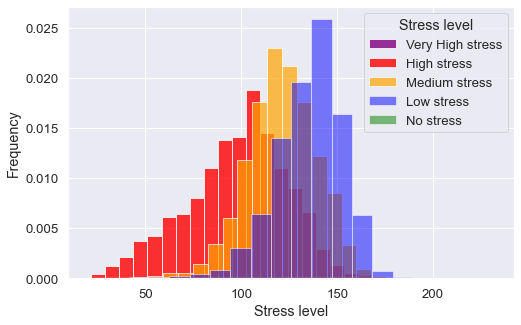

In [19]:
sns.set(font_scale=1.2)
dt = dh_class.copy()
plt.figure(figsize=(8,5))
var='YGSMN'
plt.hist(dt[dt["dh_level"]==4][var].reset_index(drop=True),color='purple', alpha=0.8, label="Very High stress", bins=20,density=True)
plt.hist(dt[dt["dh_level"]==3][var].reset_index(drop=True),color='red', alpha=0.8, label="High stress", bins=20,density=True)
plt.hist(dt[dt["dh_level"]==2][var].reset_index(drop=True), alpha=0.7,color='orange', label="Medium stress", bins=20, density=True)
plt.hist(dt[dt["dh_level"]==1][var].reset_index(drop=True), alpha=0.5, color='blue',label="Low stress", bins=20,density=True)
plt.hist(dt[dt["dh_level"]==0][var].reset_index(drop=True), alpha=0.5, color='green',label="No stress", bins=30,density=True)

plt.xlabel('Stress level')
plt.ylabel('Frequency')
#plt.xlim(5,300)
#plt.xlim(0.97, 1)
plt.legend(title='Stress level')
plt.show()

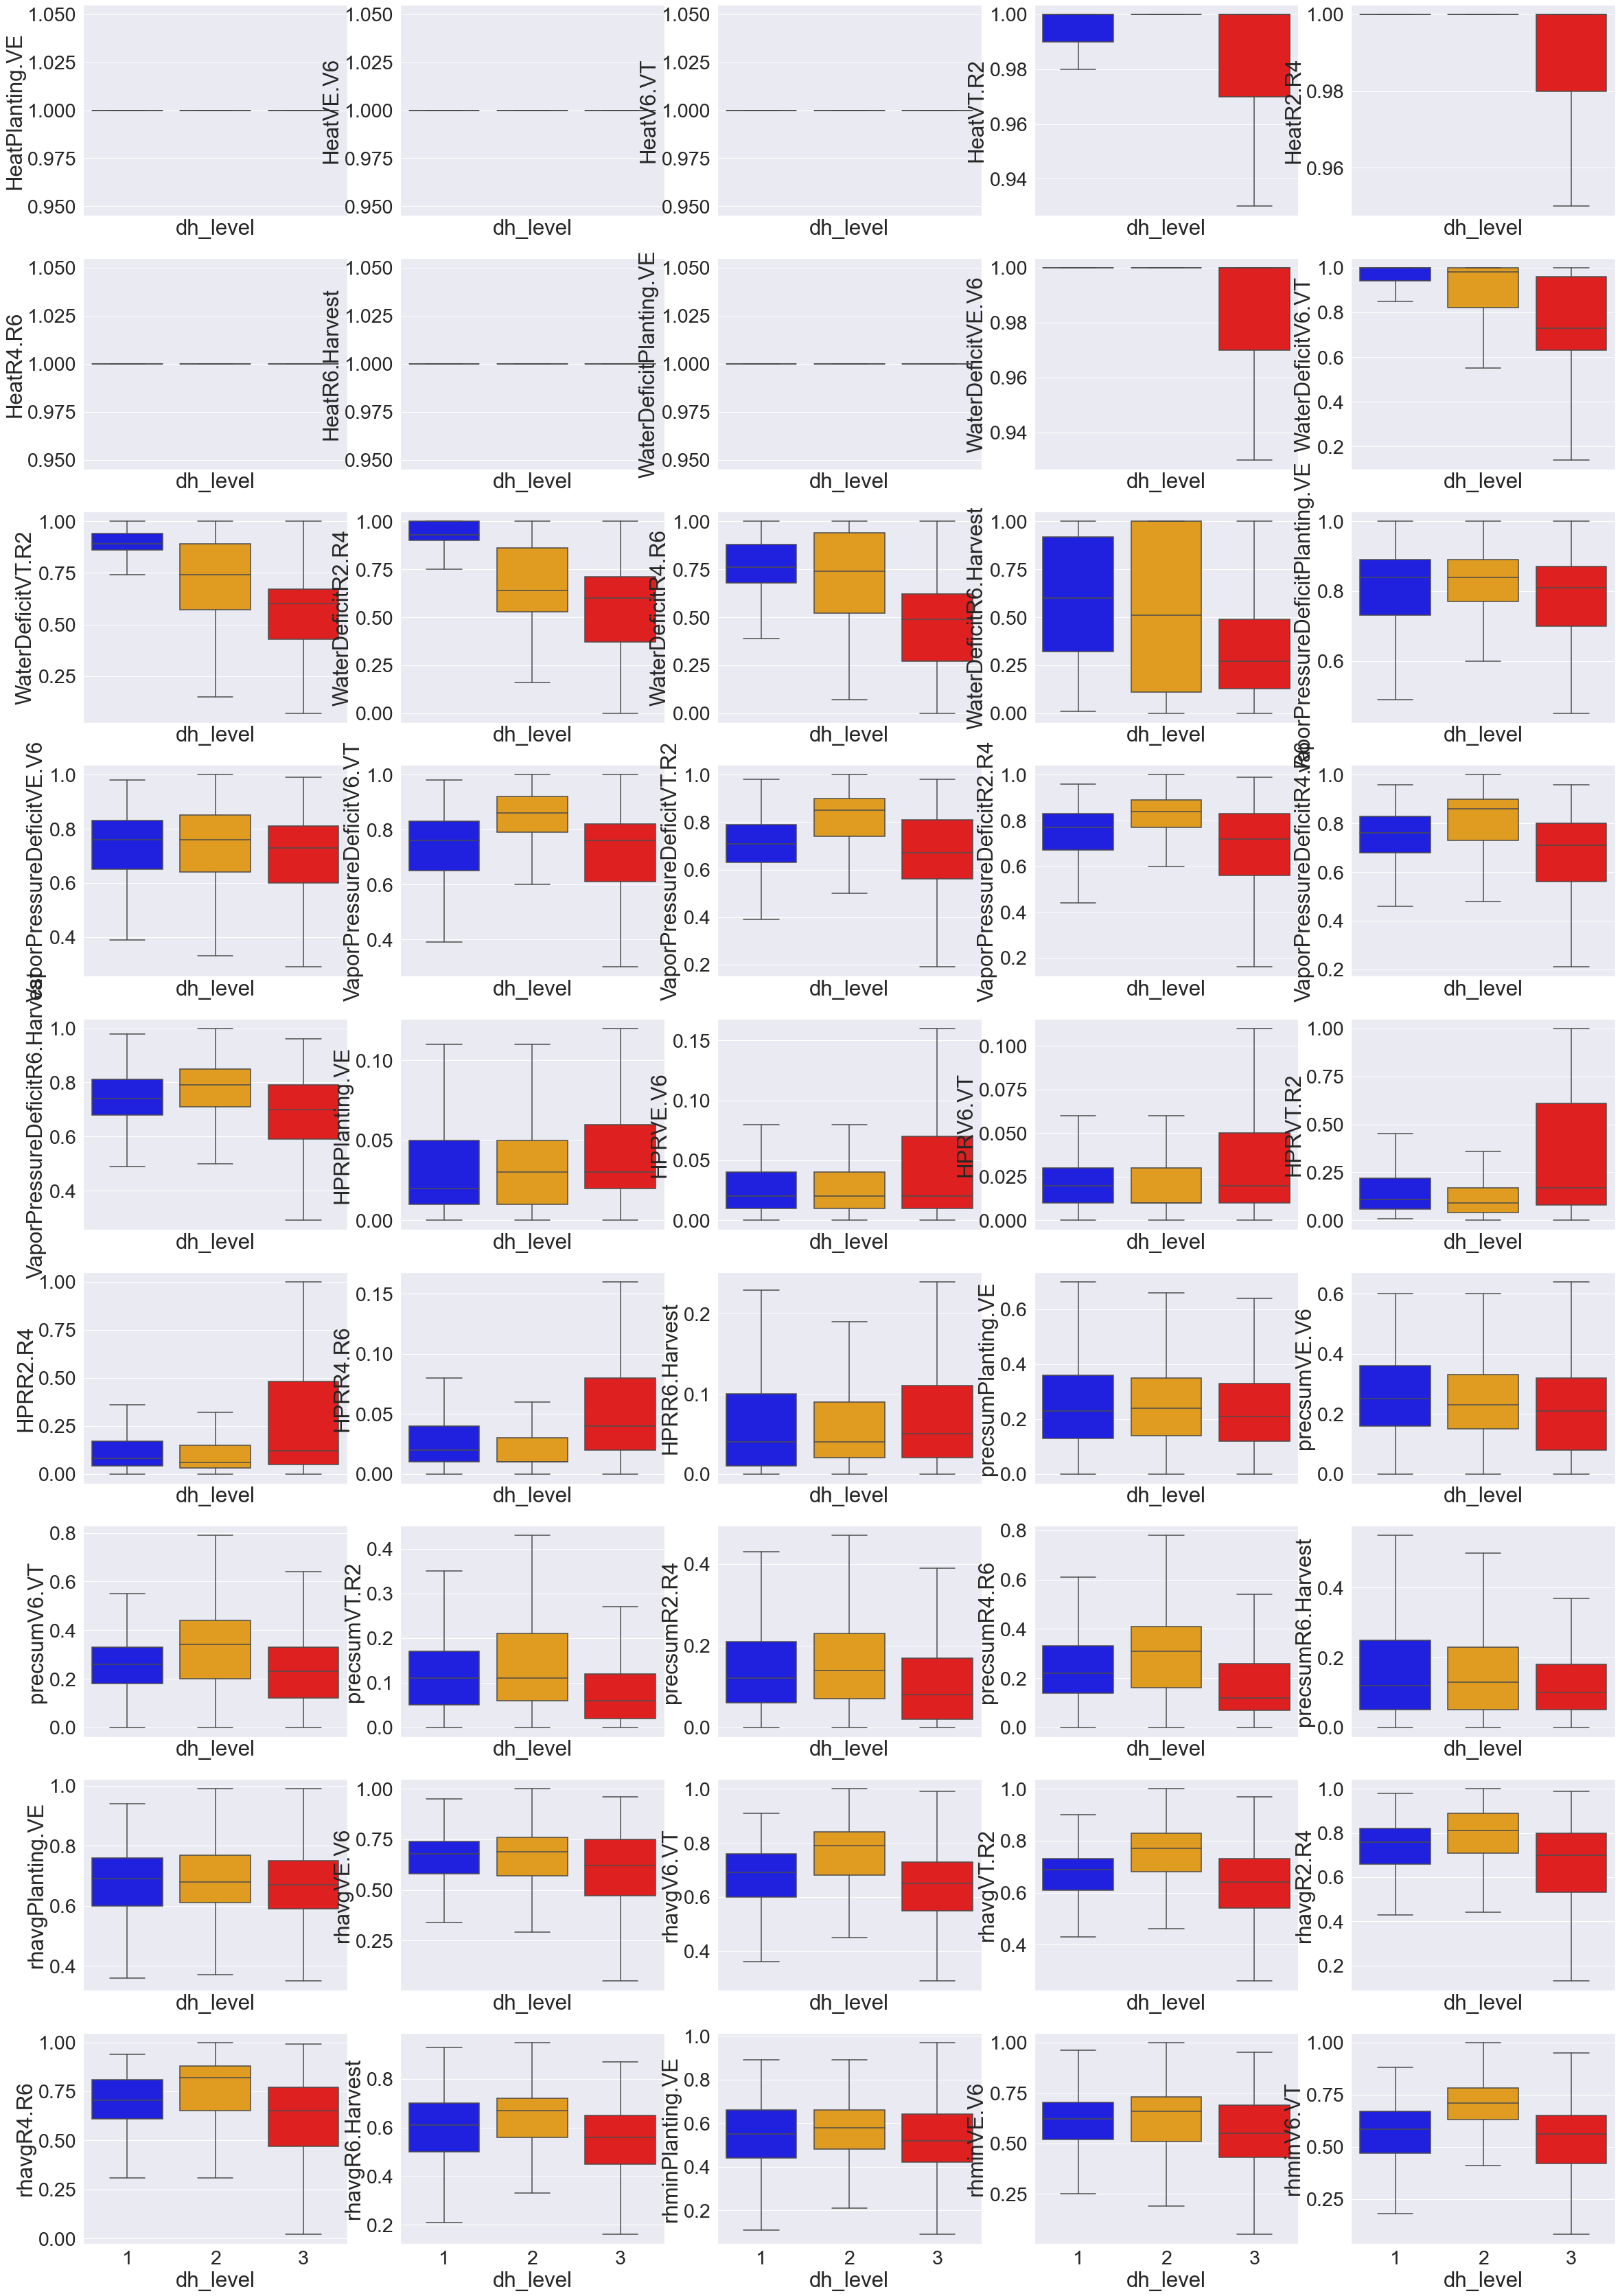

In [20]:
plt.style.use('seaborn-white')
my_pal3 = {3: "Red", 2: "orange", 1:"blue",0:'green',4:'purple'}

dh_class2 = dh_class.copy()
sns.set(font_scale = 2.6)
fig, ax = plt.subplots(9,5, sharex='col', figsize=(40, 60))

for k in range(9):
    j = k*5
    
    #my_order = dt.groupby(by=["Stress"])[dfs2.columns[j]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j]],  ax=ax[k,0], showfliers = False, palette=my_pal3)
    
   # my_order = dt.groupby(by=["Stress"])[dfs2.columns[j+1]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j+1]],  ax=ax[k,1], showfliers = False, palette=my_pal3)
    
   # my_order = dt.groupby(by=["Stress"])[dfs2.columns[j+2]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j+2]],  ax=ax[k,2], showfliers = False, palette=my_pal3)
  
   # my_order = dt.groupby(by=["Stress"])[dfs2.columns[j+3]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j+3]],  ax=ax[k,3], showfliers = False, palette=my_pal3)
    
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j+4]],  ax=ax[k,4], showfliers = False, palette=my_pal3)

## Model training & prediction 

### Prepare data 

In [24]:
dt_stress = pd.merge(dta2b, dh_class, on = drought_heat.columns.to_list())
dt_stress = dt_stress[['trial_id','dh_level']].drop_duplicates()
dta_stress = pd.merge(dta, dt_stress, on=['trial_id'])
dta_wsy = pd.get_dummies(dta_stress[['wsy_c']])
dta_stress = pd.concat([dta_stress, dta_wsy], axis=1)
dta_stress.shape
dta_stress[['wsy_c','dh_level', 'ygsmn']].groupby(['wsy_c','dh_level']).agg({'mean','count'}).sort_values(['dh_level'])

ygsmn            
                count        mean
wsy_c dh_level                   
DRY   1            12  107.540832
IRR   1         36982  137.577326
NONE  1          2079  139.443286
TILE  1          1946  137.375085
DRY   2         10858  115.480856
IRR   2          3998  127.767114
LIRR  2           129  129.122857
NONE  2         11048  125.021094
RAIN  2          2422  113.401062
TILE  2          5009  126.549022
DRY   3          6886   99.658437
IRR   3           323  108.638920
LIRR  3          3728   95.396825
NONE  3          2363  118.389254
RAIN  3          1083  101.300134

In [25]:
dh_var_or = dta_stress[drought_heat.columns.to_list()]
dh_var_or['dh_level'] =  dta_stress['dh_level']
dh_var_or2 = dh_var_or.groupby(drought_heat.columns.to_list()).agg('mean')
dh_var_or2 = dh_var_or2.reset_index()
dh_var_or2.shape
x_var = dh_var_or2.drop(['dh_level'], axis=1)
y_var = dh_var_or2['dh_level'].astype(int)

#### Model training and prediction

In [26]:
fea_tr, fea_ts, y_tr, y_ts = train_test_split(x_var, y_var, test_size=0.15, random_state=6)
rf = RandomForestClassifier(n_estimators=200, n_jobs=6)
rf.fit(fea_tr, y_tr)
    
rf_pred = rf.predict(fea_ts)
print(sklearn.metrics.r2_score(y_ts, rf_pred))

y_pred = pd.DataFrame(rf.predict(x_var))

y_all = pd.concat([y_pred, pd.DataFrame(y_var)], axis=1)
y_all.columns = ['Stress_pred','Stress']
y_all.groupby(['Stress_pred','Stress']).size()

0.9781218540021127


Stress_pred  Stress
1            1         5154
             2            8
2            1            8
             2         7211
             3            3
3            1            1
             2            6
             3         3812
dtype: int64

In [27]:
dta_stress_x = dta_stress[x_var.columns.to_list()]
y_pred2 = rf.predict(dta_stress_x)

In [28]:
dta_stress['pred_dh_level'] = y_pred2
dta_stress[['wsy_c','pred_dh_level', 'ygsmn']].groupby(['wsy_c','pred_dh_level']).agg({'mean','count'}).sort_values(['pred_dh_level'])

ygsmn            
                     count        mean
wsy_c pred_dh_level                   
DRY   1                 12  107.540832
IRR   1              37288  137.628396
NONE  1               2331  137.256976
TILE  1               1945  137.365007
DRY   2              10847  115.510271
IRR   2               3854  126.786449
LIRR  2                260  129.234387
NONE  2              10832  125.147876
RAIN  2               2422  113.401062
TILE  2               5010  126.555095
DRY   3               6897   99.637411
IRR   3                161   82.393559
LIRR  3               3597   94.160487
NONE  3               2327  118.324724
RAIN  3               1083  101.300134

In [30]:
imp = rf.feature_importances_
nms = x_var.columns

imp_var = pd.concat([pd.DataFrame(imp), pd.DataFrame(nms)],axis=1)
imp_var.columns=['Imp','Var']
imp_var.sort_values(['Imp'], ascending=False).round(3)[:10]

,Imp,Var
50,0.093,wsy_c_IRR
11,0.066,WaterDeficitR2.R4
10,0.058,WaterDeficitVT.R2
19,0.039,VaporPressureDeficitR4.R6
45,0.039,rhminVT.R2
44,0.038,rhminV6.VT
12,0.035,WaterDeficitR4.R6
16,0.033,VaporPressureDeficitV6.VT
17,0.031,VaporPressureDeficitVT.R2
38,0.029,rhavgVT.R2


### Model prediction 

#### Define function 

In [31]:
def id2year(string):
    year = string[:2]
    year = int(year)
    return year

def rf_pred_fun(dt_x, dt_y, dt_x_pred, rep=20):
    
    pred_rep = pd.DataFrame()
    for i in range(rep):
        fea_tr, fea_ts, y_tr, y_ts = train_test_split(dt_x, dt_y, test_size=0.15, random_state=6)
        rf = RandomForestClassifier(n_estimators=100, n_jobs=6)
        rf.fit(fea_tr, y_tr)
        
        cl_pred = rf.predict(dt_x_pred)
        cl_pred = pd.DataFrame(cl_pred)
        pred_rep = pd.concat([pred_rep, cl_pred], axis=1)
    return(pred_rep)

#### Read data 

In [32]:
gwas = pd.read_csv('GWAS_trials_all_new_DH_vars.csv')
gwas_var = pd.get_dummies(gwas.drop(['trial_id'], axis=1))
gwas_var[['wsy_c_RAIN', 'wsy_c_TILE', 'wsy_c_NONE']] = 0
gwas_var = gwas_var[drought_heat.columns.to_list()]
gwas_var['wsy_c'] = gwas['wsy_c']
gwas_var['trial_id'] = gwas['trial_id']
print(gwas_var.shape)
gwas_var.replace(np.inf, 10, inplace=True)
gwas_var2 = gwas_var.dropna()
gwas_var2b = gwas_var2.drop(['wsy_c','trial_id'], axis=1)
print(gwas_var2b.shape)

(2479, 57)
(2318, 55)


#### Predict

In [33]:
pred_re = rf_pred_fun(x_var, y_var, gwas_var2b, rep=100)
pred_re.shape
final_pred = pred_re.mode(axis=1)
len(final_pred)

2318

In [34]:
rf_pred1 = final_pred[0]
gwas_var2.index =  range(gwas_var2.shape[0])
gwas_var2['dh_level'] = rf_pred1

gwas_var2['DH_stress'] = gwas_var2['dh_level']
gwas_var2['DH_stress'].loc[gwas_var2['DH_stress']==1] = 'Low'
gwas_var2['DH_stress'].loc[gwas_var2['DH_stress']==2] = 'Medium'
gwas_var2['DH_stress'].loc[gwas_var2['DH_stress']==3] = 'High'
print(gwas_var2['DH_stress'].value_counts())
gwas_var2.groupby(['wsy_c','DH_stress']).size()

High      1064
Low        893
Medium     361
Name: DH_stress, dtype: int64


wsy_c  DH_stress
DRY    High           49
       Medium         82
IRR    Low           893
       Medium        234
LIRR   High         1015
       Medium         45
dtype: int64

In [36]:
gwas_var2.to_csv('./GWAS_prediction/GWAS_trial_YGSMN_stress.csv', index=False)

##### Test 

In [37]:
gwas_yg = pd.read_csv('GWAS_Trial_ALL_YGSMN.csv')
crds = pd.read_csv('GWAS_pheno_crds.csv')
gwas_var3 = pd.merge(gwas_var2, gwas_yg.drop(['wsy_c'], axis=1), on=['trial_id'])
gwas_var4 = pd.merge(gwas_var3, crds.drop(['YGSMN','LOCCD','wsy_c','GMSTP'],axis=1), on=['trial_id'])
gwas_var4['year'] = gwas_var4['trial_id'].map(id2year)
gwas_var4 = gwas_var4.loc[gwas_var4['year']>15]
gwas_var4['latitude'] = gwas_var4['latitude'].round(3)
gwas_var4['longitude'] = gwas_var4['longitude'].round(3)
gwas_var4.groupby(['wsy_c','DH_stress'])['YGSMN','GMSTP'].agg({'count','mean'})

YGSMN             GMSTP           
                count        mean count       mean
wsy_c DH_stress                                   
DRY   High         42  147.620096    42  19.768673
      Medium       63  204.973033    63  16.966541
IRR   Low         429  186.486735   431  17.796775
      Medium      372  188.336838   372  18.810135
LIRR  High        944  140.600908   944  17.607374
      Medium       88  206.154734    88  17.353093

In [38]:
pd.options.display.max_columns= None
gwas_ts = gwas_var4.loc[(gwas_var4['wsy_c']=='IRR')]
nm3 = drought_heat.columns.to_list()
nm3.append('DH_stress')
nm3.append('dh_level')
gwas_ts2 = gwas_ts.groupby(nm3)['YGSMN','GMSTP'].agg('mean')
print(gwas_ts2.shape)
gwas_ts2 = gwas_ts2.reset_index()
gwas_ts3= gwas_ts2.groupby(['DH_stress']).mean()
gwas_ts3 = gwas_ts3.reset_index()
gwas_ts3.sort_values(['DH_stress'])

(222, 2)


,DH_stress,HeatPlanting.VE,HeatVE.V6,HeatV6.VT,HeatVT.R2,HeatR2.R4,HeatR4.R6,HeatR6.Harvest,WaterDeficitPlanting.VE,WaterDeficitVE.V6,WaterDeficitV6.VT,WaterDeficitVT.R2,WaterDeficitR2.R4,WaterDeficitR4.R6,WaterDeficitR6.Harvest,VaporPressureDeficitPlanting.VE,VaporPressureDeficitVE.V6,VaporPressureDeficitV6.VT,VaporPressureDeficitVT.R2,VaporPressureDeficitR2.R4,VaporPressureDeficitR4.R6,VaporPressureDeficitR6.Harvest,HPRPlanting.VE,HPRVE.V6,HPRV6.VT,HPRVT.R2,HPRR2.R4,HPRR4.R6,HPRR6.Harvest,precsumPlanting.VE,precsumVE.V6,precsumV6.VT,precsumVT.R2,precsumR2.R4,precsumR4.R6,precsumR6.Harvest,rhavgPlanting.VE,rhavgVE.V6,rhavgV6.VT,rhavgVT.R2,rhavgR2.R4,rhavgR4.R6,rhavgR6.Harvest,rhminPlanting.VE,rhminVE.V6,rhminV6.VT,rhminVT.R2,rhminR2.R4,rhminR4.R6,rhminR6.Harvest,wsy_c_DRY,wsy_c_IRR,wsy_c_LIRR,wsy_c_NONE,wsy_c_RAIN,wsy_c_TILE,dh_level,YGSMN,GMSTP
0,Low,1.0,0.999834,0.991149,0.992736,0.998935,1.000000,1.000000,0.964751,0.964829,0.993368,0.988486,0.995257,0.877137,0.644004,0.756133,0.683606,0.588987,0.620034,0.694217,0.695974,0.779241,1.746150,1.380794,1.379891,2.518267,1.731447,0.961696,2.979809,36.801837,51.095545,87.252812,24.10209,38.107058,86.390098,38.824205,62.407083,62.515678,61.192176,64.953917,69.419851,66.613621,62.479052,38.124543,37.265037,37.524926,41.911090,45.103530,42.862837,39.325578,0,1,0,0,0,0,1,195.491414,20.108446
1,Medium,1.0,0.982308,0.946232,0.962211,0.904643,0.898075,0.979946,0.879648,0.854295,0.927141,0.921244,0.936167,0.677755,0.220227,0.696833,0.459236,0.386880,0.483228,0.465151,0.445454,0.519793,1.198057,2.120536,3.319311,3.993698,4.685363,3.415748,8.696181,27.709255,29.574575,22.593543,14.75940,14.115085,22.087164,2.539787,57.785873,47.060451,47.063583,56.115001,55.054941,50.540952,45.942982,32.231749,23.807680,23.503816,31.875951,30.413152,27.240981,21.300188,0,1,0,0,0,0,2,187.315223,18.725490


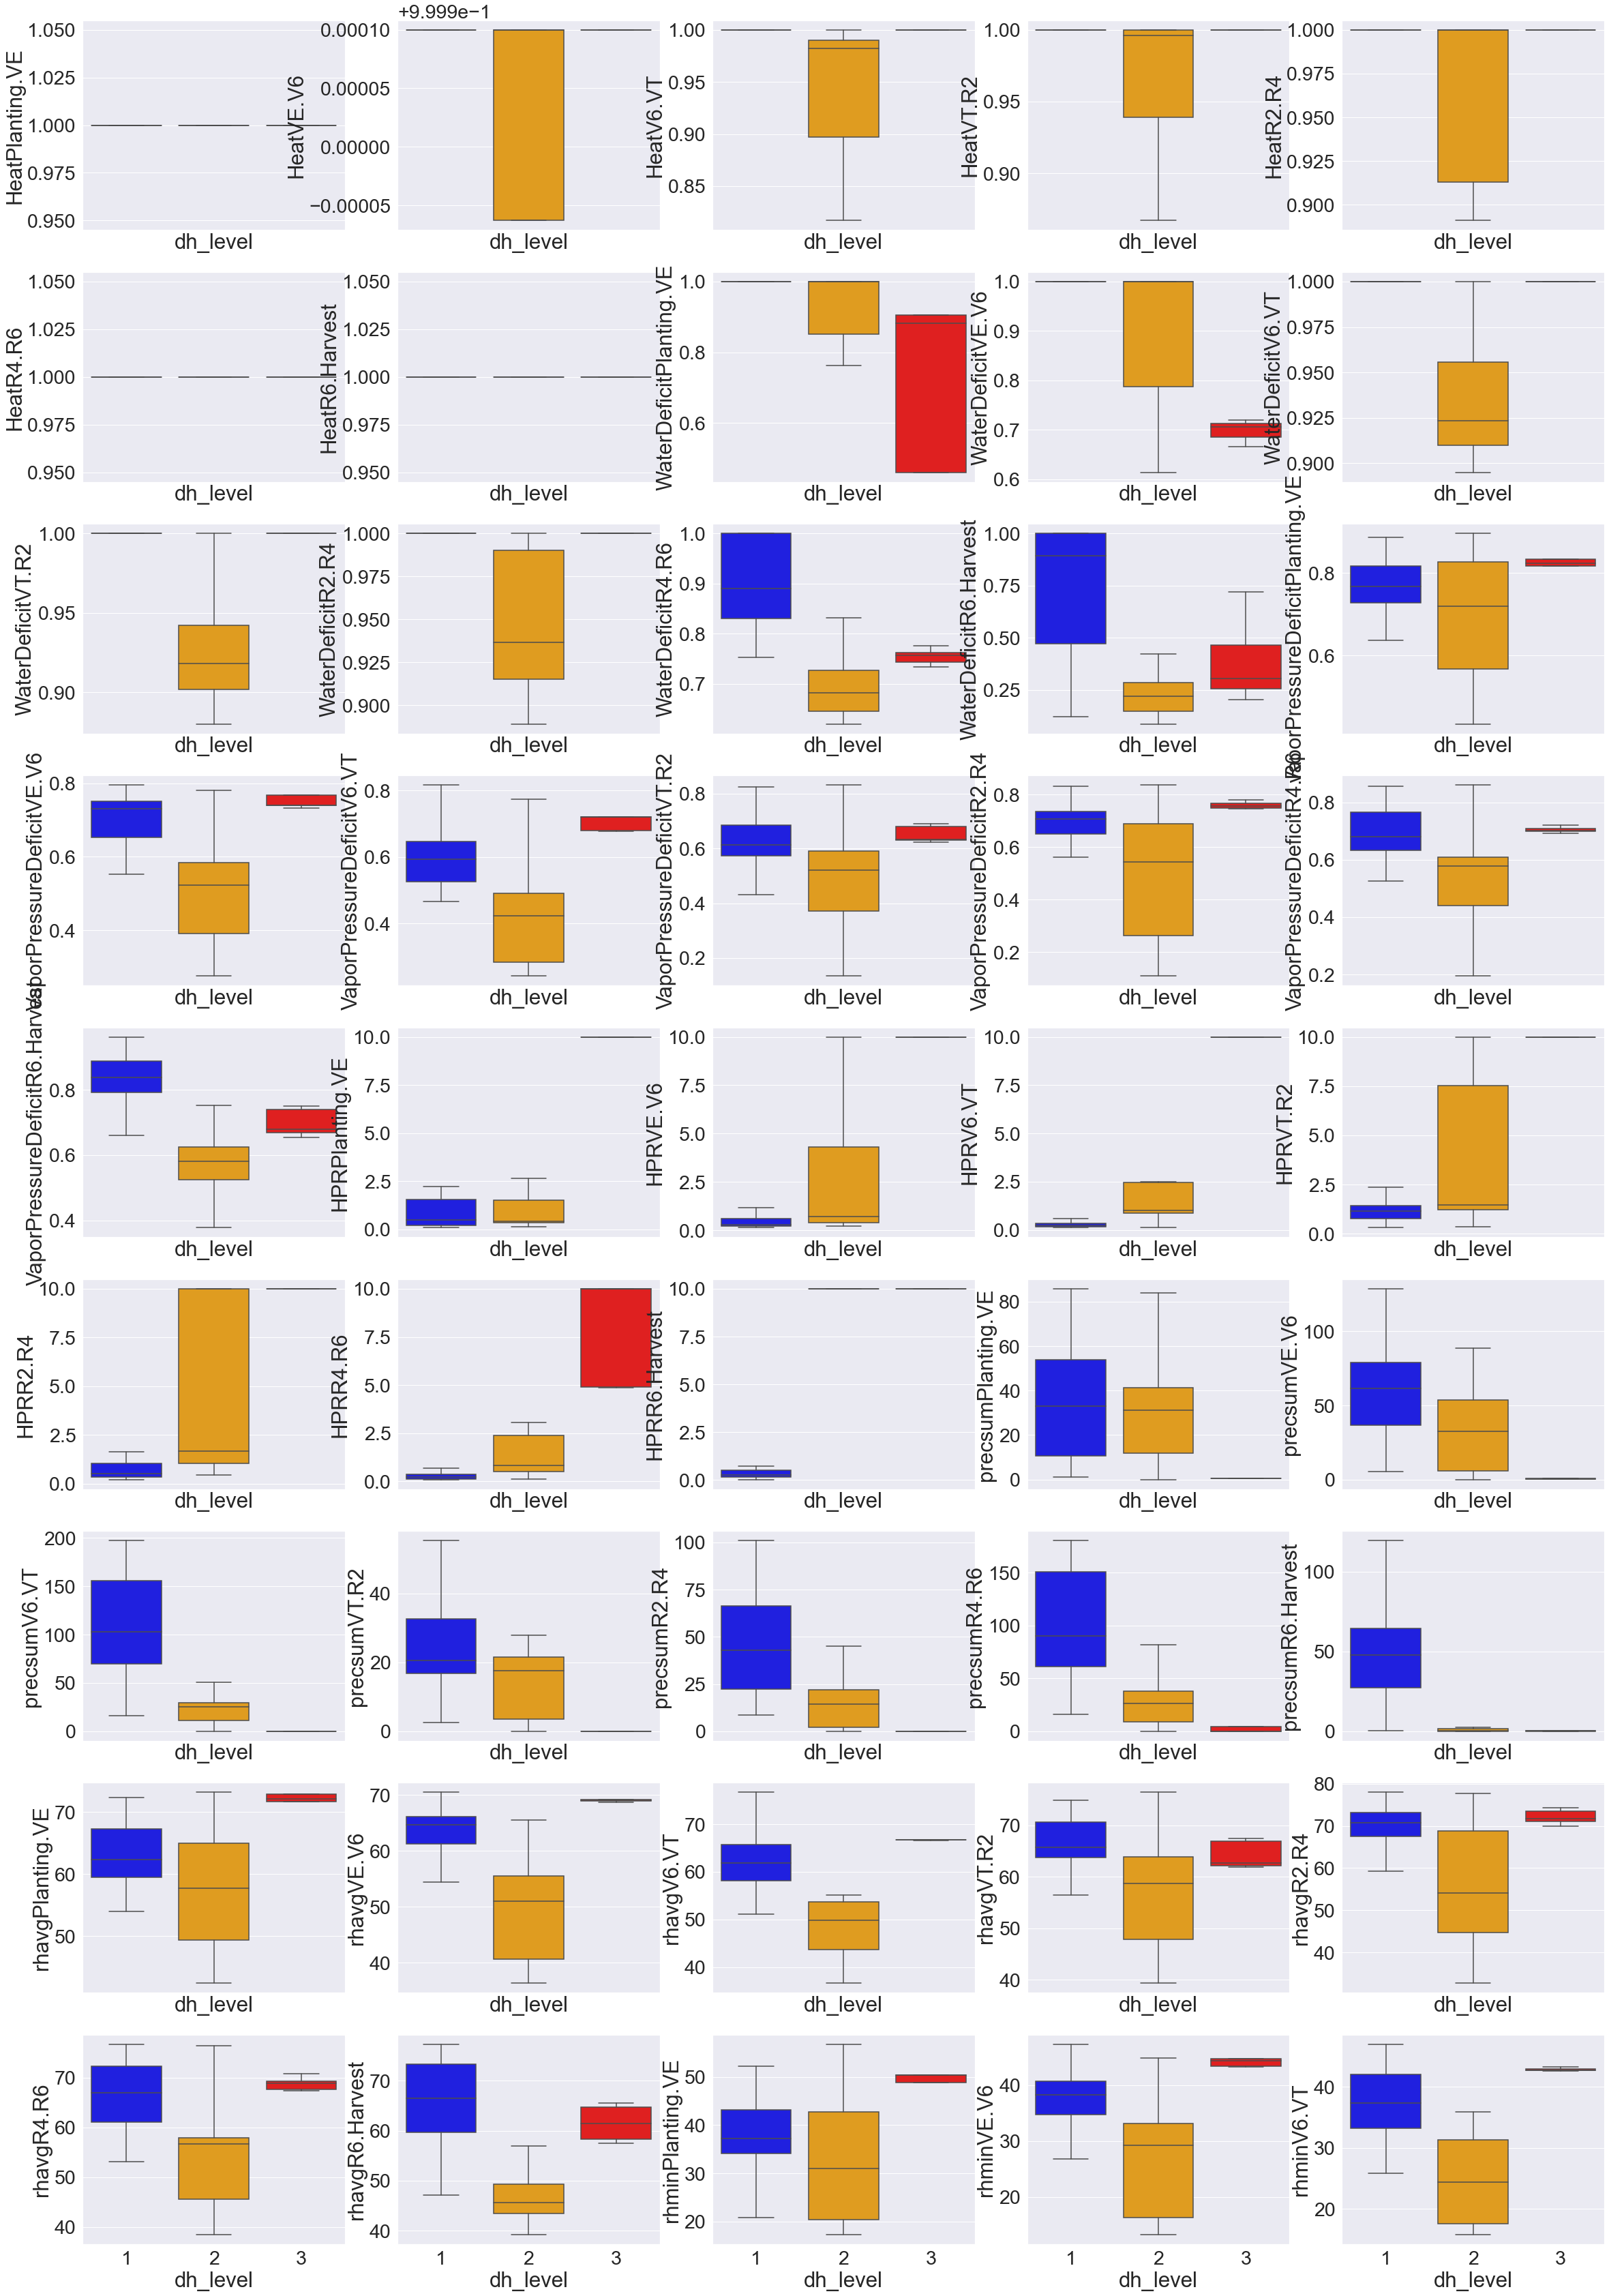

In [121]:
plt.style.use('seaborn-white')
my_pal3 = {3: "Red", 2: "orange", 1:"blue",0:'green',4:'purple'}

dh_class2 = gwas_ts2.copy()
sns.set(font_scale = 2.6)
fig, ax = plt.subplots(9,5, sharex='col', figsize=(40, 60))

#dt['ygsmn'] = dt['ygsmn']/10
for k in range(9):
    j = k*5
    
    #my_order = dt.groupby(by=["Stress"])[dfs2.columns[j]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j]],  ax=ax[k,0], showfliers = False, palette=my_pal3)
    
   # my_order = dt.groupby(by=["Stress"])[dfs2.columns[j+1]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j+1]],  ax=ax[k,1], showfliers = False, palette=my_pal3)
    
   # my_order = dt.groupby(by=["Stress"])[dfs2.columns[j+2]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j+2]],  ax=ax[k,2], showfliers = False, palette=my_pal3)
  
   # my_order = dt.groupby(by=["Stress"])[dfs2.columns[j+3]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j+3]],  ax=ax[k,3], showfliers = False, palette=my_pal3)
    
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j+4]],  ax=ax[k,4], showfliers = False, palette=my_pal3)
    

# Data-driven clustering function for GMSTP

## K-means 

### Linear model 

In [1090]:
def var_imp_cluster_li(dt_x, dt_y, n_cluster=3):
    nvar = dt_x.shape[1]
    r2A = []
    psA= []
    for i in range(nvar):
        
        fac_x2 = PolynomialFeatures(degree=1).fit_transform(dt_x.iloc[:,i].to_numpy().reshape(-1,1))
        r2s = []
        ps = []
        for k in range(20):
            fea_tr, fea_ts, y_tr, y_ts = train_test_split(fac_x2, dt_y, test_size=0.2, random_state = k*1000)
            lrm = LR().fit(fea_tr, y_tr)
            lr_pred = lrm.predict(fea_ts)

           # r2= sklearn.metrics.r2_score(y_ts, lr_pred)
            fea_pred= pd.DataFrame(lr_pred)
            fea_pred.index = y_ts.index
            fea_pred['GMSTP']= y_ts
            r2=  pearsonr(lr_pred.ravel(), y_ts['GMSTP'])[0]
            r2s.append(r2)
            p=  pearsonr(lr_pred.ravel(), y_ts['GMSTP'])[1]
            ps.append(p)
            
        mn = pd.DataFrame(r2s).median()    
        r2A.append(mn) 
        pm = pd.DataFrame(ps).median()    
        psA.append(pm) 
        
    r2A = pd.DataFrame(r2A).round(4)
    psA = pd.DataFrame(psA).round(4)
    r2A.rename(columns={0:'Coefficient'}, inplace=True)
    r2A['Coefficient'].loc[psA[0]>0.05]  = 0
    #r2A['Coefficient'] = np.sqrt(r2A['Coefficient'])
    
    for i in range(nvar):
        dt_x.iloc[:,i] = dt_x.iloc[:,i]*r2A['Coefficient'][i]
    
    clusters_df1 = pd.DataFrame()
    sse_ls1 = []
    for rp in range(10):
        kmns = KMeans(n_clusters=n_cluster, n_init=15, max_iter=500, init='k-means++')
        kmns.fit(dt_x)

        lb = kmns.labels_
        lb_df = pd.DataFrame(lb)
        clusters_df1 = pd.concat([clusters_df1, lb_df], axis=1)

        sses = kmns.inertia_
        sse_ls1.append(sses)

    sse_df1 = pd.DataFrame(sse_ls1)
    ind1 = sse_df1[0].argmin(axis=0)
    clusters= clusters_df1.iloc[:,ind1]
    return(clusters)

### RF Model 

In [1094]:
def var_imp_cluster_rf(dt_x, dt_y, n_cluster=3):

    nvar = dt_x.shape[1]

    psA= []
    for i in range(nvar):

        fac_x2 = PolynomialFeatures(degree=1).fit_transform(dt_x.iloc[:,i].to_numpy().reshape(-1,1))
        r2s = []
        ps = []
        for k in range(20):
            fea_tr, fea_ts, y_tr, y_ts = train_test_split(fac_x2, dt_y, test_size=0.2, random_state = k*1000)
            lrm = LR().fit(fea_tr, y_tr)
            lr_pred = lrm.predict(fea_ts)

           # r2= sklearn.metrics.r2_score(y_ts, lr_pred)
            fea_pred= pd.DataFrame(lr_pred)
            fea_pred.index = y_ts.index
            fea_pred['GMSTP']= y_ts
            r2=  pearsonr(lr_pred.ravel(), y_ts['GMSTP'])[0]
            r2s.append(r2)
            p=  pearsonr(lr_pred.ravel(), y_ts['GMSTP'])[1]
            ps.append(p)

        mn = pd.DataFrame(r2s).median()
        pm = pd.DataFrame(ps).median()
        psA.append(pm)

    psA = pd.DataFrame(psA).round(3)
    
    dt_x = dt_x.loc[:,((psA[0]<0.05)|(psA[0]==0.05))]

    rf = RandomForestRegressor(n_estimators=100, n_jobs=6)
    rf.fit(dt_x, dt_y)
    r2A = rf.feature_importances_
    r2A = pd.DataFrame(r2A).round(3)
    r2A.rename(columns={0:'Coefficient'}, inplace=True)
    #r2A['Coefficient'].loc[psA[0]>0.05]  = 0
    nvar = dt_x.shape[1]

    for i in range(nvar):
        dt_x.iloc[:,i] = dt_x.iloc[:,i]*r2A['Coefficient'][i]


    clusters_df1 = pd.DataFrame()
    sse_ls1 = []
    for rp in range(10):
        kmns = KMeans(n_clusters=n_cluster, n_init=15, max_iter=500, init='k-means++')
        kmns.fit(dt_x)

        lb = kmns.labels_
        lb_df = pd.DataFrame(lb)
        clusters_df1 = pd.concat([clusters_df1, lb_df], axis=1)

        sses = kmns.inertia_
        sse_ls1.append(sses)

    sse_df1 = pd.DataFrame(sse_ls1)
    ind1 = sse_df1[0].argmin(axis=0)
    clusters= clusters_df1.iloc[:,ind1]
    return(clusters)

## Hierachical 

### Linear model 

In [39]:
def var_imp_cluster_li(dt_x, dt_y, n_cluster=3):
    nvar = dt_x.shape[1]
    r2A = []
    psA= []
    for i in range(nvar):
        
        fac_x2 = PolynomialFeatures(degree=1).fit_transform(dt_x.iloc[:,i].to_numpy().reshape(-1,1))
        r2s = []
        ps = []
        for k in range(20):
            fea_tr, fea_ts, y_tr, y_ts = train_test_split(fac_x2, dt_y, test_size=0.25, random_state = k*1000)
            lrm = LR().fit(fea_tr, y_tr)
            lr_pred = lrm.predict(fea_ts)

           # r2= sklearn.metrics.r2_score(y_ts, lr_pred)
            fea_pred= pd.DataFrame(lr_pred)
            fea_pred.index = y_ts.index
            fea_pred['GMSTP']= y_ts
            r2=  pearsonr(lr_pred.ravel(), y_ts['GMSTP'])[0]
            r2s.append(r2)
            p=  pearsonr(lr_pred.ravel(), y_ts['GMSTP'])[1]
            ps.append(p)
            
        mn = pd.DataFrame(r2s).median()    
        r2A.append(mn) 
        pm = pd.DataFrame(ps).median()    
        psA.append(pm) 
        
    r2A = pd.DataFrame(r2A).round(4)
    psA = pd.DataFrame(psA).round(4)
    r2A.rename(columns={0:'Coefficient'}, inplace=True)
    r2A['Coefficient'].loc[psA[0]>0.05]  = 0
    #r2A['Coefficient'] = np.sqrt(r2A['Coefficient'])
    
    for i in range(nvar):
        dt_x.iloc[:,i] = dt_x.iloc[:,i]*r2A['Coefficient'][i]
    
    clusters_df1 = pd.DataFrame()
    sse_ls1 = []
    for i in range(nvar):
        dt_x.iloc[:,i] = dt_x.iloc[:,i]*r2A['Coefficient'][i]


    clusters_df1 = pd.DataFrame()
    sse_ls1 = []
    for rp in range(1):
        kmns = AgglomerativeClustering(n_clusters= n_cluster)
        kmns.fit(dt_x)

        lb = kmns.labels_
        lb_df = pd.DataFrame(lb)
        
    clusters= lb_df
    return(clusters)

### RF model 

In [40]:
def var_imp_cluster_rf(dt_x, dt_y, n_cluster=3):

    nvar = dt_x.shape[1]

    psA= []
    for i in range(nvar):

        fac_x2 = PolynomialFeatures(degree=1).fit_transform(dt_x.iloc[:,i].to_numpy().reshape(-1,1))
        r2s = []
        ps = []
        for k in range(20):
            fea_tr, fea_ts, y_tr, y_ts = train_test_split(fac_x2, dt_y, test_size=0.25, random_state = k*1000)
            lrm = LR().fit(fea_tr, y_tr)
            lr_pred = lrm.predict(fea_ts)

           # r2= sklearn.metrics.r2_score(y_ts, lr_pred)
            fea_pred= pd.DataFrame(lr_pred)
            fea_pred.index = y_ts.index
            fea_pred['GMSTP']= y_ts
            r2=  pearsonr(lr_pred.ravel(), y_ts['GMSTP'])[0]
            r2s.append(r2)
            p=  pearsonr(lr_pred.ravel(), y_ts['GMSTP'])[1]
            ps.append(p)

        mn = pd.DataFrame(r2s).median()
        pm = pd.DataFrame(ps).median()
        psA.append(pm)

    psA = pd.DataFrame(psA).round(3)
    
    dt_x = dt_x.loc[:,((psA[0]<0.05)|(psA[0]==0.05))]

    rf = RandomForestRegressor(n_estimators=100, n_jobs=6)
    rf.fit(dt_x, dt_y)
    r2A = rf.feature_importances_
    r2A = pd.DataFrame(r2A).round(3)
    r2A.rename(columns={0:'Coefficient'}, inplace=True)
    #r2A['Coefficient'].loc[psA[0]>0.05]  = 0
    nvar = dt_x.shape[1]

    for i in range(nvar):
        dt_x.iloc[:,i] = dt_x.iloc[:,i]*r2A['Coefficient'][i]


    clusters_df1 = pd.DataFrame()
    sse_ls1 = []
    for rp in range(1):
        kmns = AgglomerativeClustering(n_clusters= n_cluster)
        kmns.fit(dt_x)

        lb = kmns.labels_
        lb_df = pd.DataFrame(lb)
        
    clusters= lb_df
    
    return(clusters)

# GMSTP

## Prepare data 

In [46]:
os.chdir('C:/Users/s1052014/OneDrive - Syngenta/Desktop/NA_corn_WO/Data2021/Drought Stress/corn dataset')

In [47]:
nms = ['HeatPlanting.VE','HeatVE.V6', 'HeatV6.VT', 'HeatVT.R2', 'HeatR2.R4', 'HeatR4.R6','HeatR6.Harvest',
            'WaterDeficitPlanting.VE', 'WaterDeficitVE.V6', 'WaterDeficitV6.VT', 'WaterDeficitVT.R2', 'WaterDeficitR2.R4','WaterDeficitR4.R6','WaterDeficitR6.Harvest',
            'VaporPressureDeficitPlanting.VE', 'VaporPressureDeficitVE.V6', 'VaporPressureDeficitV6.VT', 'VaporPressureDeficitVT.R2', 'VaporPressureDeficitR2.R4',
             'VaporPressureDeficitR4.R6','VaporPressureDeficitR6.Harvest','HPRPlanting.VE','HPRVE.V6','HPRV6.VT', 'HPRVT.R2', 'HPRR2.R4', 'HPRR4.R6','HPRR6.Harvest',
 'wsy_c','precsumPlanting.VE',  'precsumVE.V6', 'precsumV6.VT', 'precsumVT.R2', 'precsumR2.R4',
       'precsumR4.R6', 'precsumR6.Harvest', 
 'rhavgPlanting.VE', 'rhavgVE.V6', 'rhavgV6.VT', 'rhavgVT.R2', 'rhavgR2.R4','rhavgR4.R6','rhavgR6.Harvest', 'rhminPlanting.VE','rhminVE.V6', 'rhminV6.VT',
       'rhminVT.R2', 'rhminR2.R4', 'rhminR4.R6', 'rhminR6.Harvest']

In [48]:
gwas = pd.read_csv('GWAS_YGSMN_dh_ENV.csv')
gwas_dt = gwas[nms]
gwas_dt['trial_id'] = gwas['trial_id']
gwas_dt['GMSTP'] = gwas['GMSTP']
gwas_dt.columns

Index(['HeatPlanting.VE', 'HeatVE.V6', 'HeatV6.VT', 'HeatVT.R2', 'HeatR2.R4',
       'HeatR4.R6', 'HeatR6.Harvest', 'WaterDeficitPlanting.VE',
       'WaterDeficitVE.V6', 'WaterDeficitV6.VT', 'WaterDeficitVT.R2',
       'WaterDeficitR2.R4', 'WaterDeficitR4.R6', 'WaterDeficitR6.Harvest',
       'VaporPressureDeficitPlanting.VE', 'VaporPressureDeficitVE.V6',
       'VaporPressureDeficitV6.VT', 'VaporPressureDeficitVT.R2',
       'VaporPressureDeficitR2.R4', 'VaporPressureDeficitR4.R6',
       'VaporPressureDeficitR6.Harvest', 'HPRPlanting.VE', 'HPRVE.V6',
       'HPRV6.VT', 'HPRVT.R2', 'HPRR2.R4', 'HPRR4.R6', 'HPRR6.Harvest',
       'wsy_c', 'precsumPlanting.VE', 'precsumVE.V6', 'precsumV6.VT',
       'precsumVT.R2', 'precsumR2.R4', 'precsumR4.R6', 'precsumR6.Harvest',
       'rhavgPlanting.VE', 'rhavgVE.V6', 'rhavgV6.VT', 'rhavgVT.R2',
       'rhavgR2.R4', 'rhavgR4.R6', 'rhavgR6.Harvest', 'rhminPlanting.VE',
       'rhminVE.V6', 'rhminV6.VT', 'rhminVT.R2', 'rhminR2.R4', 'rhminR4.R6',
  

In [49]:
dta = pd.read_csv('Environment_2009_2021_YGSMN_trial.csv')
dta = dta.loc[dta['Market_segment']=='West']
dta = dta.dropna(subset=['GMSTP'])
dta = dta.loc[~(dta['wsy_c']=='ECO')]
dta = dta[gwas_dt.columns.to_list()]
dta = pd.concat([dta, gwas_dt], axis=0)
dta.index = range(dta.shape[0])
dta.shape

(20962, 52)

In [50]:
from sklearn.preprocessing import MinMaxScaler
dta2 = dta[nms]

dta2 = pd.get_dummies(dta2)
dta2b = MinMaxScaler().fit_transform(dta2)
dta2b = dta2b.round(2)
dta2b = pd.DataFrame(dta2b)
dta2b.columns= dta2.columns
dta2b.index = dta.index
dta2b['wsy_c'] = dta['wsy_c']
dta2b['GMSTP'] = dta['GMSTP']
dta2b['trial_id'] = dta['trial_id']

dta3 = dta2b.groupby(dta2.columns.to_list()).agg('mean')
dta3 = dta3.reset_index()
dta3 = dta3.dropna()
print(dta3.shape)
dt_y = dta3[['GMSTP']]
drought_heat = dta3.drop(['GMSTP'],axis=1)
print(drought_heat.shape)

(6254, 56)
(6254, 55)


## Characterization

In [52]:
dh_var = drought_heat.loc[:,round(drought_heat.std(axis=0),6)>0]
dh_cp = FactorAnalyzer(n_factors=40, rotation="varimax", method="principal",  is_corr_matrix=False).fit(dh_var)
print(dh_cp.get_factor_variance())
dh_fac = pd.DataFrame(dh_cp.transform(dh_var))

(array([13.07054387,  6.81020322,  3.86371418,  3.43558769,  2.65190525,
        2.62962908,  1.49915158,  1.28211196,  1.19842452,  1.18413177,
        1.14143744,  1.11104281,  1.06173788,  1.04936489,  1.03252131,
        1.00962202,  0.99436559,  0.97745394,  0.93531697,  0.86458909,
        0.77215271,  0.76750317,  0.76171434,  0.62199737,  0.60115034,
        0.39524178,  0.3923423 ,  0.30546463,  0.29280746,  0.29261324,
        0.23420891,  0.23276898,  0.22076191,  0.19802976,  0.19297162,
        0.17532473,  0.17133256,  0.116822  ,  0.09352178,  0.09021217]), array([0.23764625, 0.12382188, 0.07024935, 0.06246523, 0.04821646,
       0.04781144, 0.0272573 , 0.02331113, 0.02178954, 0.02152967,
       0.02075341, 0.02020078, 0.01930433, 0.01907936, 0.01877311,
       0.01835676, 0.01807937, 0.01777189, 0.01700576, 0.0157198 ,
       0.01403914, 0.0139546 , 0.01384935, 0.01130904, 0.01093001,
       0.00718621, 0.0071335 , 0.0055539 , 0.00532377, 0.00532024,
       0.00425834, 

In [53]:
dh_cluster = var_imp_cluster_li(dh_fac, dt_y,n_cluster=20)

In [54]:
lrm = RandomForestRegressor(n_estimators=128, n_jobs=6).fit(dh_var, dt_y)
lr_pred = lrm.predict(dh_var)
dh_var2 = dh_var.copy()
dh_var2['pred_GMSTP'] = lr_pred
dh_var2['pred_GMSTP'] = dh_var2['pred_GMSTP'].round(2)
print(dh_var2['pred_GMSTP'].quantile([0.33,0.67]))

0.33    18.37
0.67    21.85
Name: pred_GMSTP, dtype: float64


In [55]:
dh_var2 = dh_var.copy()
dh_var2['pred_GMSTP'] = lr_pred
dh_var2['pred_GMSTP'] = dh_var2['pred_GMSTP'].round(2)
dh_var2['cluster'] = dh_cluster
dh_var2['GMSTP'] = dta3['GMSTP']
dh_class= dh_var2.groupby(['cluster']).agg('median').sort_values(['pred_GMSTP'])
dh_class = dh_class.reset_index()
dh_class['dh_level']=3
dh_class['dh_level'].loc[dh_class['pred_GMSTP']>=18.5]=2
dh_class['dh_level'].loc[dh_class['pred_GMSTP']>21.5]=1
print(dh_class)
dh_class = pd.merge(dh_var2, dh_class[['cluster','dh_level']], on=['cluster'], how='left')
dh_class['dh_level'].value_counts()

    cluster  HeatPlanting.VE  HeatVE.V6  HeatV6.VT  HeatVT.R2  HeatR2.R4  \
0         1              1.0        0.6       0.49       0.64       0.58   
1         5              1.0        1.0       1.00       1.00       1.00   
2        12              1.0        1.0       1.00       1.00       1.00   
3         3              1.0        1.0       0.98       0.99       0.99   
4        10              1.0        1.0       0.94       0.94       0.99   
5         9              1.0        1.0       1.00       0.99       1.00   
6        16              1.0        1.0       1.00       1.00       1.00   
7        19              1.0        1.0       0.98       1.00       1.00   
8        15              1.0        1.0       1.00       1.00       1.00   
9         7              1.0        1.0       1.00       1.00       1.00   
10        8              1.0        1.0       1.00       1.00       1.00   
11       14              1.0        1.0       0.99       0.99       1.00   
12        0 

2    4289
1    1274
3     691
Name: dh_level, dtype: int64

In [56]:
dh_var2['dh_level'] = dh_class['dh_level']
dh_var2[['GMSTP','dh_level']].groupby(['dh_level']).median()

,GMSTP
dh_level,
1,23.288194
2,19.777168
3,17.388889


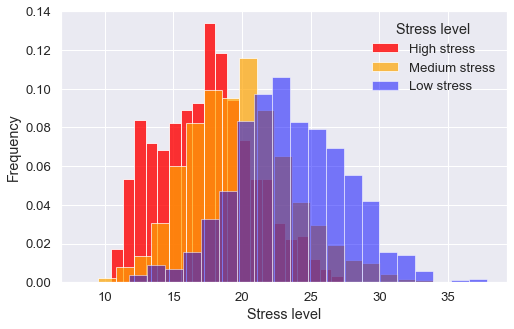

In [57]:
sns.set(font_scale=1.2)
dt = dh_class.copy()
plt.figure(figsize=(8,5))
var='GMSTP'

plt.hist(dt[dt["dh_level"]==3][var].reset_index(drop=True),color='red', alpha=0.8, label="High stress", bins=20,density=True)
plt.hist(dt[dt["dh_level"]==2][var].reset_index(drop=True), alpha=0.7,color='orange', label="Medium stress", bins=20, density=True)
plt.hist(dt[dt["dh_level"]==1][var].reset_index(drop=True), alpha=0.5, color='blue',label="Low stress", bins=20,density=True)

plt.xlabel('Stress level')
plt.ylabel('Frequency')
#plt.xlim(5,300)
#plt.xlim(0.97, 1)
plt.legend(title='Stress level')
plt.show()

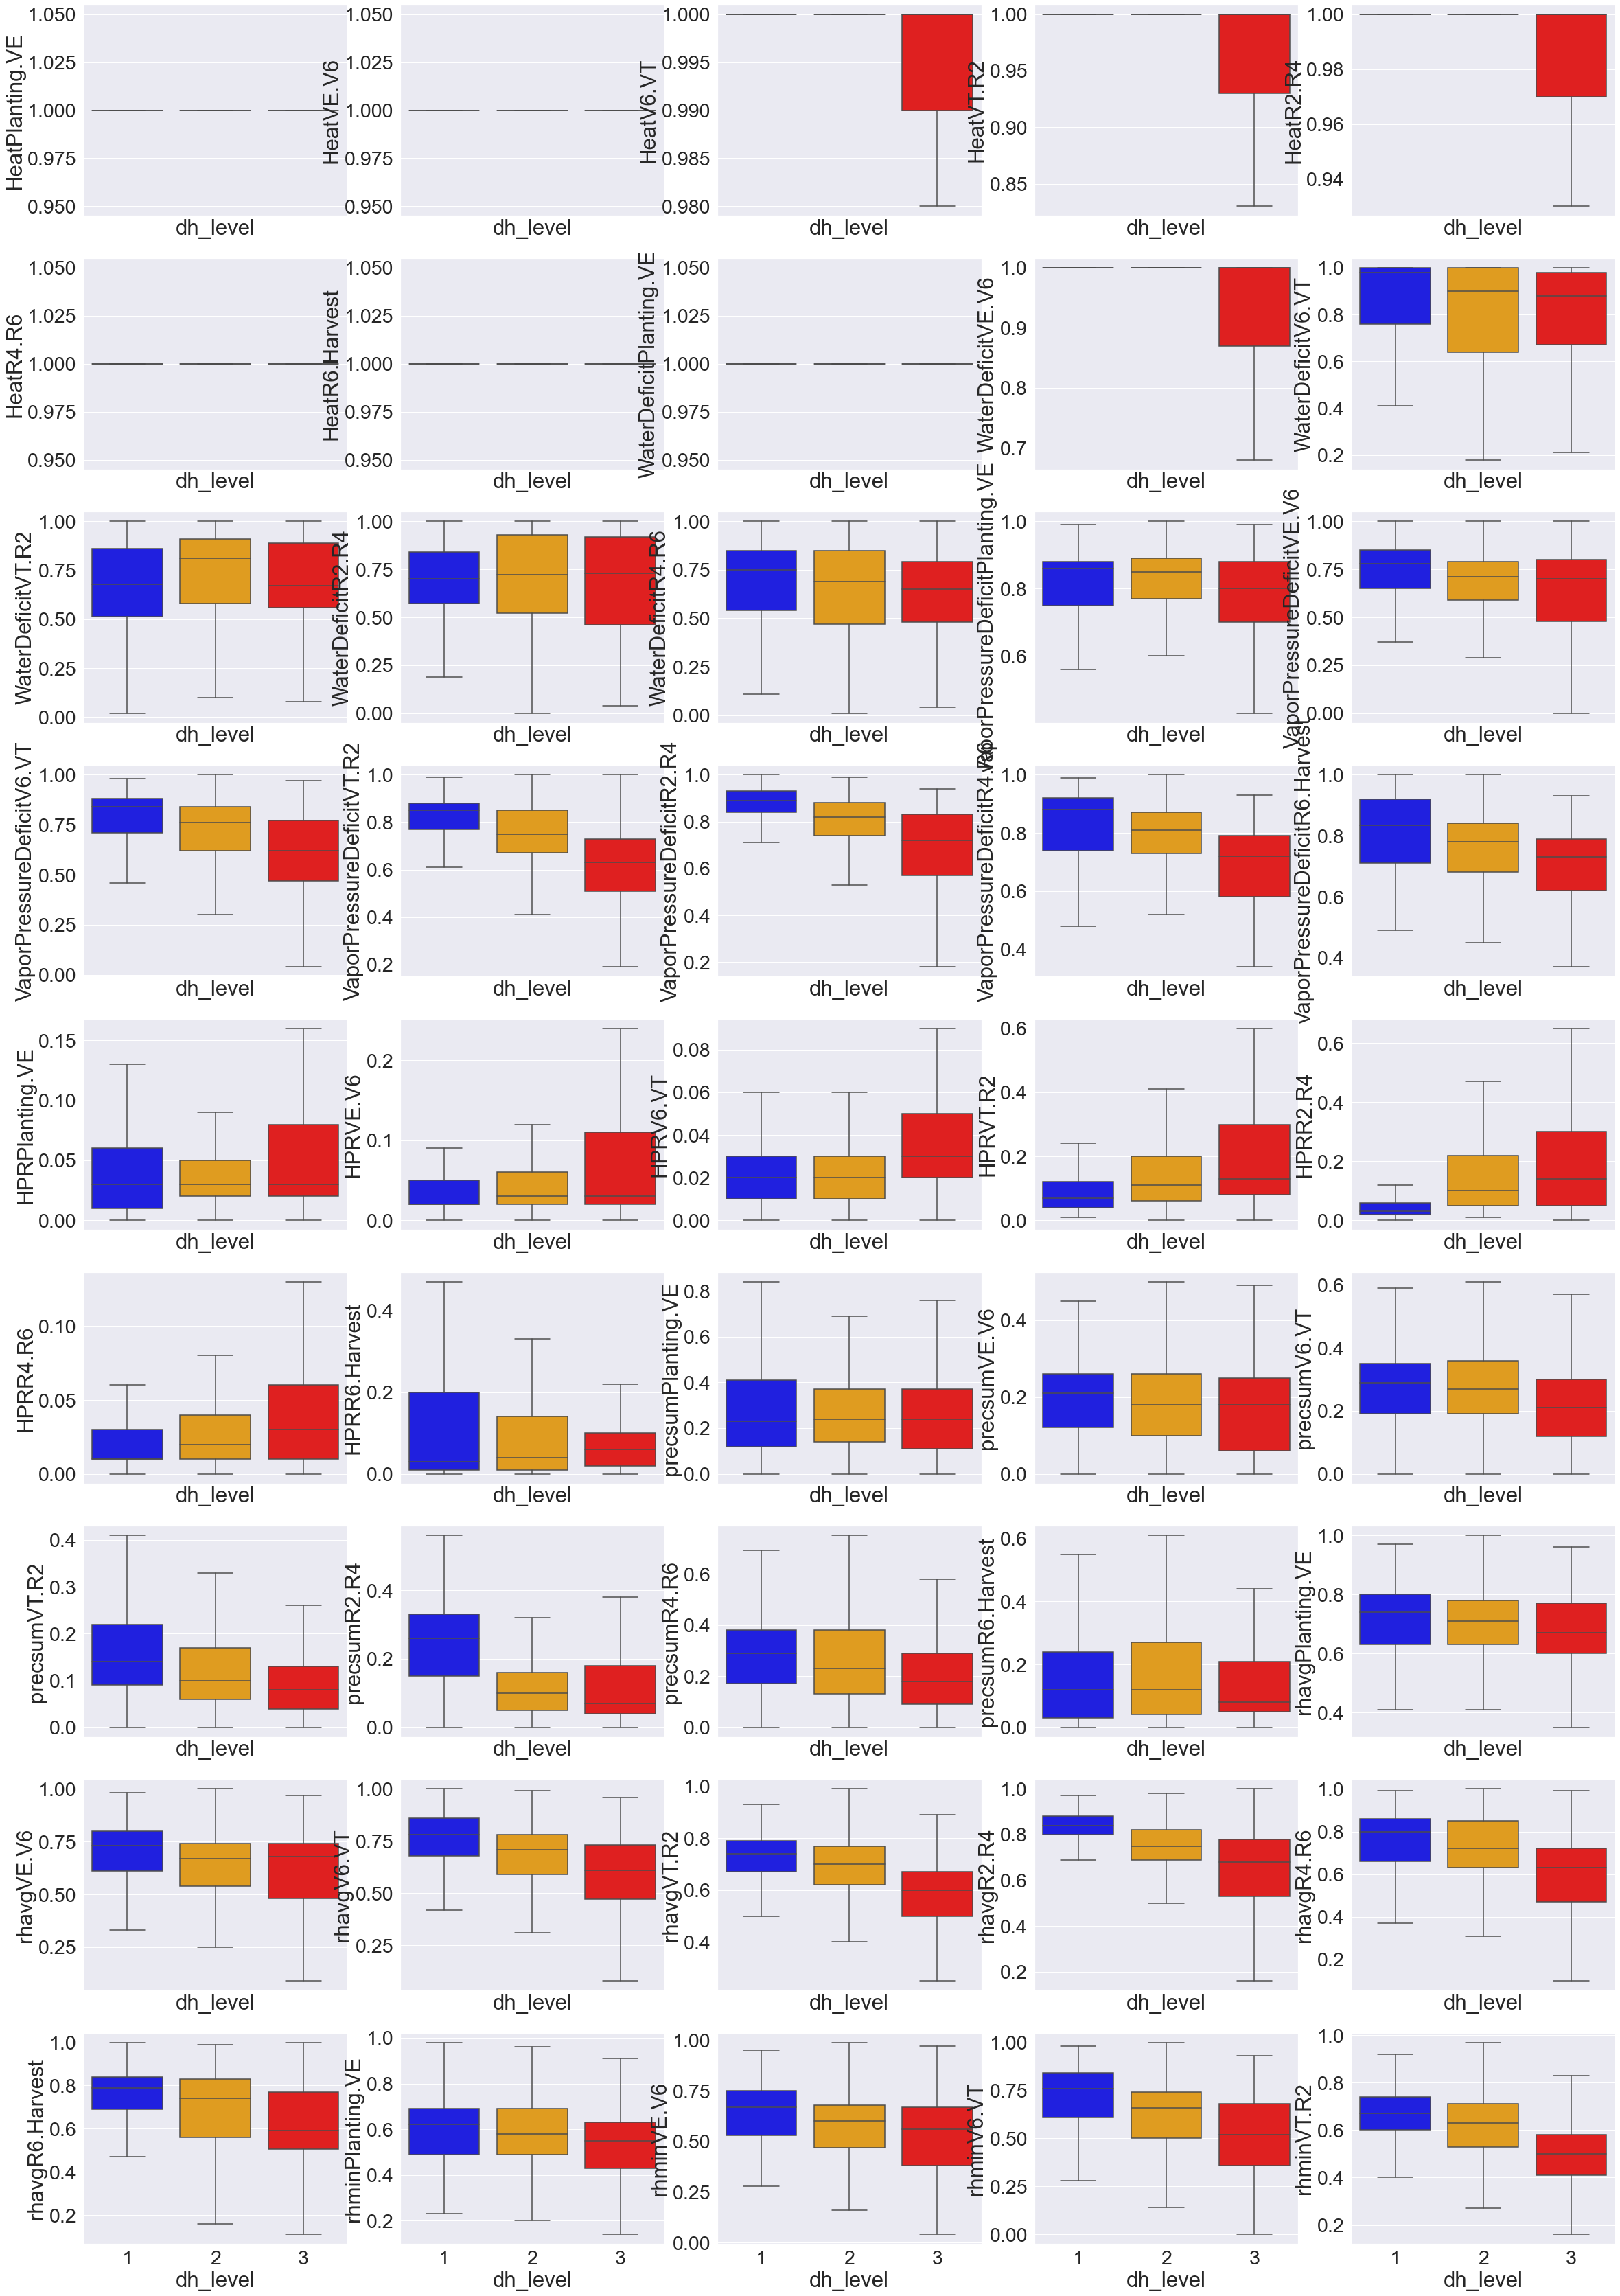

In [1116]:
plt.style.use('seaborn-white')
my_pal3 = {3: "Red", 2: "orange", 1:"blue",0:'green',4:'purple'}

dh_class2 = dh_class.copy()
sns.set(font_scale = 2.6)
fig, ax = plt.subplots(9,5, sharex='col', figsize=(40, 60))

#dt['ygsmn'] = dt['ygsmn']/10
for k in range(9):
    j = k*5
    
    #my_order = dt.groupby(by=["Stress"])[dfs2.columns[j]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j]],  ax=ax[k,0], showfliers = False, palette=my_pal3)
    
   # my_order = dt.groupby(by=["Stress"])[dfs2.columns[j+1]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j+1]],  ax=ax[k,1], showfliers = False, palette=my_pal3)
    
   # my_order = dt.groupby(by=["Stress"])[dfs2.columns[j+2]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j+2]],  ax=ax[k,2], showfliers = False, palette=my_pal3)
  
   # my_order = dt.groupby(by=["Stress"])[dfs2.columns[j+3]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j+3]],  ax=ax[k,3], showfliers = False, palette=my_pal3)
    
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j+4]],  ax=ax[k,4], showfliers = False, palette=my_pal3)

## Model training & prediction 

### Prepare data 

In [58]:
dt_stress = pd.merge(dta2b, dh_class, on = drought_heat.columns.to_list())
dt_stress = dt_stress[['trial_id','dh_level']].drop_duplicates()
dta_stress = pd.merge(dta, dt_stress, on=['trial_id'])
dta_wsy = pd.get_dummies(dta_stress[['wsy_c']])
dta_stress = pd.concat([dta_stress, dta_wsy], axis=1)
dta_stress.shape
dta_stress[['wsy_c','dh_level', 'GMSTP']].groupby(['wsy_c','dh_level']).agg({'mean','count'}).sort_values(['dh_level'])

GMSTP           
               count       mean
wsy_c dh_level                 
DRY   1          159  20.172762
RAIN  1          128  22.616575
IRR   1          407  25.276332
NONE  1          377  23.785097
LIRR  1          118  25.445987
TILE  1         2103  23.502161
RAIN  2         1164  19.097130
NONE  2         3222  20.498617
TILE  2          766  20.804924
IRR   2         7584  20.147826
DRY   2         1419  19.471274
LIRR  2         1317  18.445366
IRR   3         1285  17.272553
NONE  3          223  20.484090
DRY   3          202  15.685127
RAIN  3          188  18.417152
LIRR  3          396  15.362761

In [59]:
dh_var_or = dta_stress[drought_heat.columns.to_list()]
dh_var_or['dh_level'] =  dta_stress['dh_level']
dh_var_or2 = dh_var_or.groupby(drought_heat.columns.to_list()).agg('mean')
dh_var_or2 = dh_var_or2.reset_index()
dh_var_or2.shape
x_var = dh_var_or2.drop(['dh_level'], axis=1)
y_var = dh_var_or2['dh_level'].astype(int)

### Model training and prediction

In [60]:
fea_tr, fea_ts, y_tr, y_ts = train_test_split(x_var, y_var, test_size=0.15, random_state=6)
rf = RandomForestClassifier(n_estimators=200, n_jobs=6)
rf.fit(fea_tr, y_tr)
    
rf_pred = rf.predict(fea_ts)
print(sklearn.metrics.r2_score(y_ts, rf_pred))

y_pred = pd.DataFrame(rf.predict(x_var))

y_all = pd.concat([y_pred, pd.DataFrame(y_var)], axis=1)
y_all.columns = ['Stress_pred','Stress']
y_all.groupby(['Stress_pred','Stress']).size()

0.8643771125060358


Stress_pred  Stress
1            1         1278
             2            3
2            1           16
             2         4408
             3           14
3            2            9
             3          687
dtype: int64

In [61]:
imp = rf.feature_importances_
nms = x_var.columns

imp_var = pd.concat([pd.DataFrame(imp), pd.DataFrame(nms)],axis=1)
imp_var.columns=['Imp','Var']
imp_var.sort_values(['Imp'], ascending=False).round(3)[:10]

,Imp,Var
54,0.085,wsy_c_TILE
13,0.053,WaterDeficitR6.Harvest
34,0.044,precsumR6.Harvest
16,0.042,VaporPressureDeficitV6.VT
27,0.032,HPRR6.Harvest
37,0.031,rhavgV6.VT
44,0.027,rhminV6.VT
41,0.026,rhavgR6.Harvest
12,0.025,WaterDeficitR4.R6
43,0.024,rhminVE.V6


### Model prediction 

#### Read data 

In [62]:
gwas = pd.read_csv('GWAS_trials_all_new_DH_vars.csv')
gwas_var = pd.get_dummies(gwas.drop(['trial_id'], axis=1))
gwas_var[['wsy_c_RAIN', 'wsy_c_TILE', 'wsy_c_NONE']] = 0
gwas_var = gwas_var[drought_heat.columns.to_list()]
gwas_var['wsy_c'] = gwas['wsy_c']
gwas_var['trial_id'] = gwas['trial_id']
print(gwas_var.shape)
gwas_var.replace(np.inf, 10, inplace=True)
gwas_var2 = gwas_var.dropna()
gwas_var2b = gwas_var2.drop(['wsy_c','trial_id'], axis=1)
print(gwas_var2b.shape)

(2479, 57)
(2318, 55)


#### Predict 

In [63]:
pred_re = rf_pred_fun(x_var, y_var, gwas_var2b, rep=10)
pred_re.shape
final_pred = pred_re.mode(axis=1)
len(final_pred)

rf_pred1 = final_pred[0]
gwas_var2.index =  range(gwas_var2.shape[0])
gwas_var2['dh_level'] = rf_pred1

gwas_var2['DH_stress'] = gwas_var2['dh_level']
gwas_var2['DH_stress'].loc[gwas_var2['DH_stress']==1] = 'Low'
gwas_var2['DH_stress'].loc[gwas_var2['DH_stress']==2] = 'Medium'
gwas_var2['DH_stress'].loc[gwas_var2['DH_stress']==3] = 'High'
print(gwas_var2['DH_stress'].value_counts())

gwas_var2.groupby(['wsy_c','DH_stress']).size()

Medium    1725
High       341
Low        252
Name: DH_stress, dtype: int64


wsy_c  DH_stress
DRY    High          49
       Medium        82
IRR    High         131
       Low          175
       Medium       821
LIRR   High         161
       Low           77
       Medium       822
dtype: int64

In [64]:
gwas_var2.to_csv('./GWAS_prediction/GWAS_trial_GMSTP_stress.csv', index=False)

##### Test 

In [65]:
gwas_yg = pd.read_csv('GWAS_Trial_ALL_YGSMN.csv')
crds = pd.read_csv('GWAS_pheno_crds.csv')
gwas_var3 = pd.merge(gwas_var2, gwas_yg.drop(['wsy_c','GMSTP'], axis=1), on=['trial_id'])
gwas_var4 = pd.merge(gwas_var3, crds.drop(['YGSMN','LOCCD','wsy_c'],axis=1), on=['trial_id'])
gwas_var4['year'] = gwas_var4['trial_id'].map(id2year)
gwas_var4 = gwas_var4.loc[gwas_var4['year']>15]
gwas_var4['latitude'] = gwas_var4['latitude'].round(3)
gwas_var4['longitude'] = gwas_var4['longitude'].round(3)
gwas_var4.groupby(['wsy_c','DH_stress'])['YGSMN','GMSTP'].agg({'count','mean'})

YGSMN             GMSTP           
                count        mean count       mean
wsy_c DH_stress                                   
DRY   High         30  208.169258    30  16.496330
      Medium       75  171.576898    75  18.723819
IRR   High        147  170.204096   149  14.140042
      Low          27  189.352642    27  25.833877
      Medium      627  191.278453   627  18.920892
LIRR  High        226  156.695262   226  14.567925
      Low          45  152.432052    45  24.785560
      Medium      761  142.702105   761  18.056152

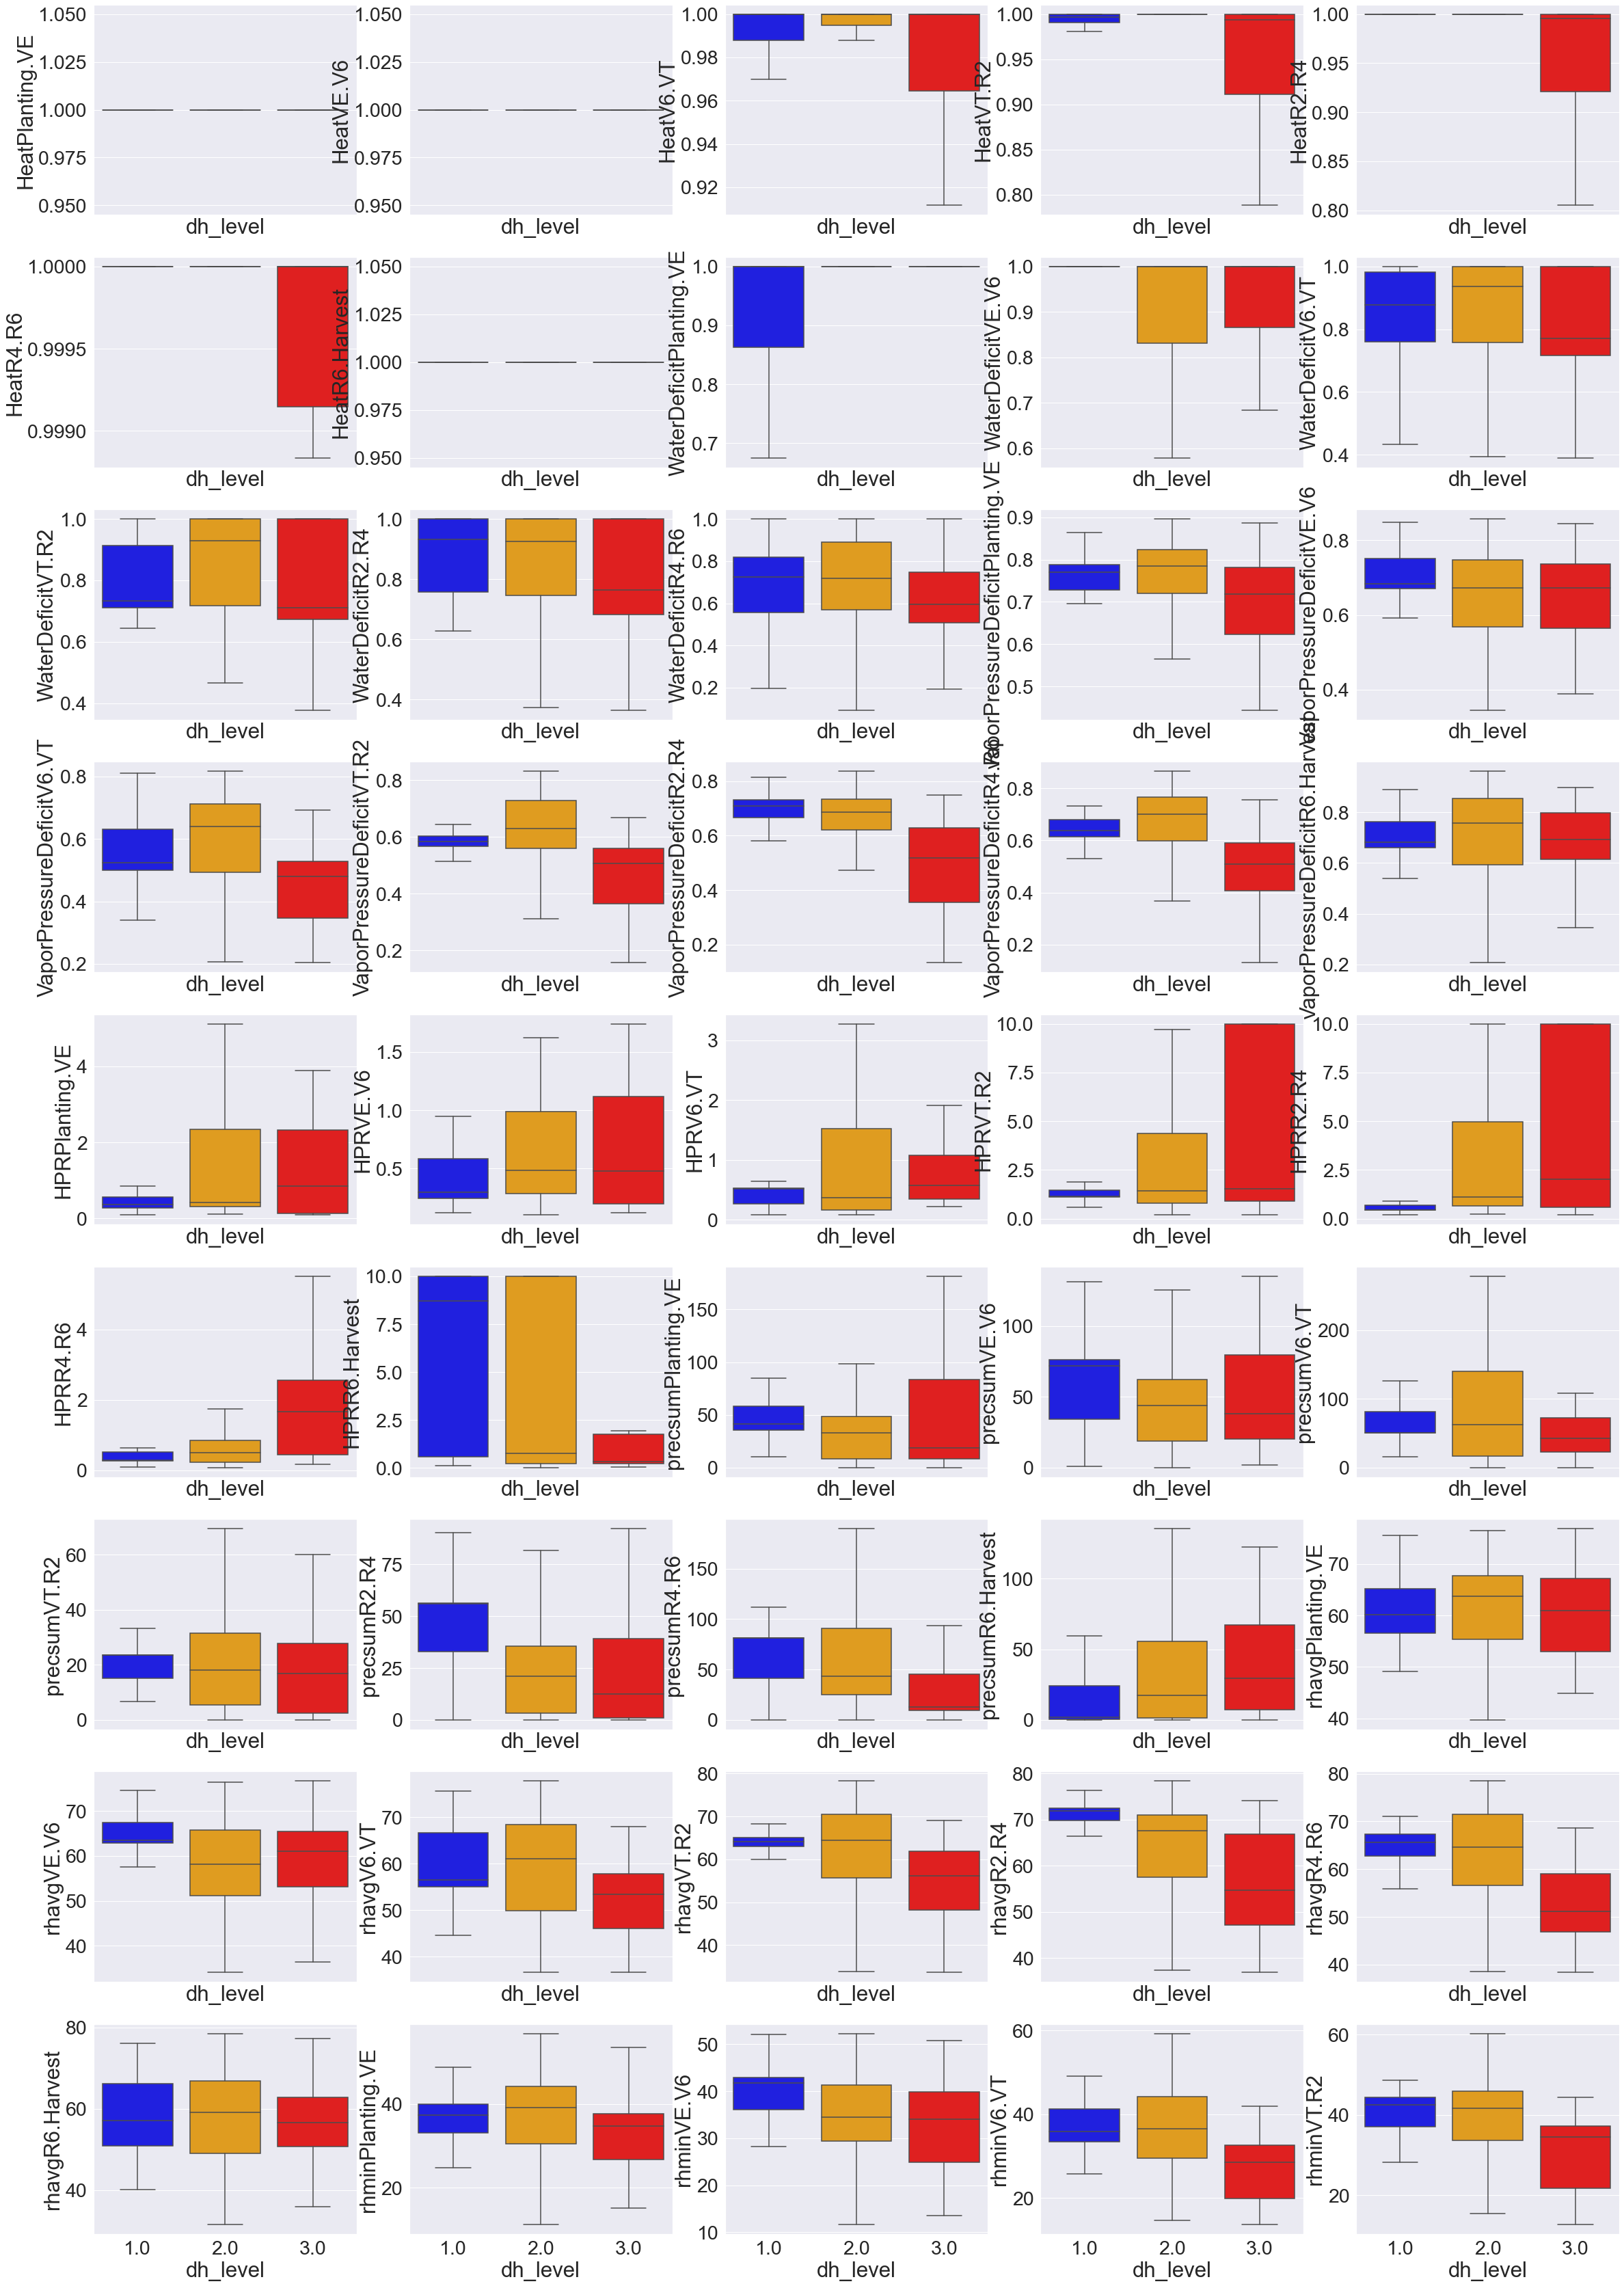

In [1129]:
plt.style.use('seaborn-white')
my_pal3 = {3: "Red", 2: "orange", 1:"blue",0:'green',4:'purple'}


dh_class2 = gwas_var2.copy()
sns.set(font_scale = 2.6)
fig, ax = plt.subplots(9,5, sharex='col', figsize=(40, 60))

#dt['ygsmn'] = dt['ygsmn']/10
for k in range(9):
    j = k*5
    
    #my_order = dt.groupby(by=["Stress"])[dfs2.columns[j]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j]],  ax=ax[k,0], showfliers = False, palette=my_pal3)
    
   # my_order = dt.groupby(by=["Stress"])[dfs2.columns[j+1]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j+1]],  ax=ax[k,1], showfliers = False, palette=my_pal3)
    
   # my_order = dt.groupby(by=["Stress"])[dfs2.columns[j+2]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j+2]],  ax=ax[k,2], showfliers = False, palette=my_pal3)
  
   # my_order = dt.groupby(by=["Stress"])[dfs2.columns[j+3]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j+3]],  ax=ax[k,3], showfliers = False, palette=my_pal3)
    
    sns.boxplot(x=dh_class2['dh_level'], y=dh_class2[dh_class2.columns[j+4]],  ax=ax[k,4], showfliers = False, palette=my_pal3)
    

# Test results 

## Evaluate 1 results 

In [ ]:
#dfs = pd.read_csv('Stress_NA_Corn_16_21_ML_West_with_Env.csv')
my_pal3 = {"High": "red", "Medium": "orange", "Low":"blue"}
my_pal2 = {"Very_high": "purple",'High':'red', "Meidum_2": "orange", 'Meidum_1':'blue', "Low":"green",'Very_Low':'lightblue'}
#my_pal3 = {"Very_high": "purple",'High':'red', "Medium_2": "orange", 'Medium_1':'blue', "Low":"green"}
#my_pal3 = {4: "purple",3:'red', 2: "orange", 1:'blue', 0:"green"}
#my_pal3 = {3: "purple", 2: "orange", 1:"green"}
my_pal3 = {3: "Red", 2: "orange", 1:"blue"}

### Histogram plot 

In [ ]:
#plt.style.available

In [ ]:
dt_a2.groupby(['Stress']).size()

In [ ]:
fig, ax = plt.subplots(1,2,  figsize=(15, 6))
plt.style.use('seaborn-white')

#dfs = dt_a2.loc[dt_a2.Market_segment=='West']

my_order = dfs.groupby(by=["Stress"])['ygsmn'].mean().sort_values(ascending=False).index
sns.violinplot(x=dfs['Stress'], y=dfs['ygsmn'],  ax=ax[0], showfliers = False, palette=my_pal3, order=my_order)

my_order = dfs.groupby(by=["Stress"])['Percent_yield_gap'].mean().sort_values(ascending=False).index
sns.violinplot(x=dfs['Stress'], y=dfs['Percent_yield_gap'], ax=ax[1],  showfliers = False, palette=my_pal3, order=my_order)

In [ ]:
dfs2 =dfs[['WaterDeficitV6-VT', 'WaterDeficitVT-R2',
       'WaterDeficitR2-R4', 'WaterDeficitR4-R6',
       'VaporPressureDeficitV6-VT', 'VaporPressureDeficitVT-R2',
       'VaporPressureDeficitR2-R4', 'VaporPressureDeficitR4-R6', 'rhavgV6-VT', 'rhavgVT-R2', 'rhavgR2-R4', 'rhavgR4-R6',
       'precsumV6-VT', 'precsumVT-R2', 'precsumR2-R4',
      'precsumR4-R6','HPRV6-VT', 'HPRVT-R2', 'HPRR2-R4', 'HPRR4-R6', 'HeatV6-VT','HeatVT-R2', 'HeatR2-R4', 'HeatR4-R6',
        'Stress']]
sns.set(font_scale =4)
fig, ax = plt.subplots(6, 4, sharex='col',figsize=(50, 60))
dt = dfs2.copy()
#dt['ygsmn'] = dt['ygsmn']/10
for k in range(6):
    j = k*4
    
    my_order = dt.groupby(by=["Stress"])[dfs2.columns[j]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dfs2['Stress'], y=dfs2[dfs2.columns[j]],  ax=ax[k,0], showfliers = False, palette=my_pal3, order=my_order)
    
    my_order = dt.groupby(by=["Stress"])[dfs2.columns[j+1]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dfs2['Stress'], y=dfs2[dfs2.columns[j+1]],  ax=ax[k,1], showfliers = False, palette=my_pal3, order=my_order)
    
    my_order = dt.groupby(by=["Stress"])[dfs2.columns[j+2]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dfs2['Stress'], y=dfs2[dfs2.columns[j+2]],  ax=ax[k,2], showfliers = False, palette=my_pal3, order=my_order)
  
    my_order = dt.groupby(by=["Stress"])[dfs2.columns[j+3]].mean().sort_values(ascending=False).index
    sns.boxplot(x=dfs2['Stress'], y=dfs2[dfs2.columns[j+3]],  ax=ax[k,3], showfliers = False, palette=my_pal3, order=my_order)

## Compare 2 results 

In [ ]:
#dfs = pd.read_csv('Stress_NA_Corn_16_21_ML.csv')
#dfs2 = pd.read_csv('Stress_NA_Corn_16_21_ML_West_with_Env.csv')

In [337]:
print(dh_class2.groupby(by=["dh_level2"])[var].agg({'count','median'}))
print(dh_class1.groupby(by=["dh_level1"])[var].agg({'count','median'}))

               median  count
dh_level2                   
1          138.341608   4569
2          120.994290   7008
3          100.881845   3025
               median  count
dh_level1                   
1          138.575966   4054
2          123.004537   7098
3          103.369191   3450


In [339]:
dh2 = pd.merge(dh_class1, dh_class2, on=dh_var.columns.to_list())
dh2.groupby(['dh_level1','dh_level2']).size()

dh_level1  dh_level2
1          1            3631
           2             422
           3               1
2          1             905
           2            5482
           3             711
3          1              33
           2            1104
           3            2313
dtype: int64

In [340]:
(3631 + 5482 + 2313)/dh2.shape[0]

0.7824955485549925

<AxesSubplot:xlabel='dh_level2', ylabel='YGSMN'>

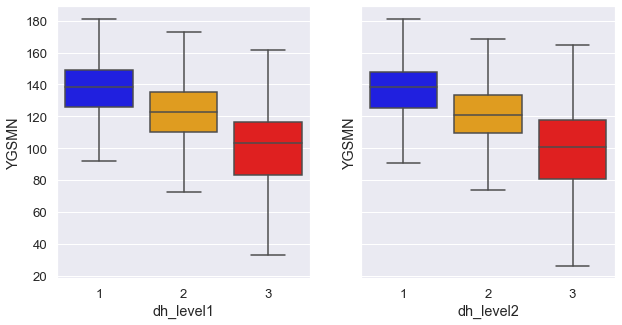

In [334]:
ts= dh_class.copy()
fig, ax = plt.subplots(1,2, sharex='col', sharey='row', figsize=(10, 5))
my_pal3 = {3: "Red", 2: "orange", 1:"blue"}


var='YGSMN'
my_order =dh_class1.groupby(by=["dh_level1"])[var].mean().sort_values(ascending=False).index
sns.boxplot(x=dh_class1['dh_level1'], y=dh_class1[var],  ax=ax[0], showfliers = False, palette=my_pal3, order=my_order)

my_order = dh_class2.groupby(by=["dh_level2"])[var].mean().sort_values(ascending=False).index
sns.boxplot(x=dh_class2['dh_level2'], y=dh_class2[var], ax=ax[1],  showfliers = False, palette=my_pal3, order=my_order)

In [ ]:
dfs1b = ts[['WaterDeficitV6-VT', 'WaterDeficitVT-R2',
       'WaterDeficitR2-R4', 'WaterDeficitR4-R6',
       'VaporPressureDeficitV6-VT', 'VaporPressureDeficitVT-R2',
       'VaporPressureDeficitR2-R4', 'VaporPressureDeficitR4-R6', 'rhavgV6-VT', 'rhavgVT-R2', 'rhavgR2-R4', 'rhavgR4-R6',
       'HPRV6-VT', 'HPRVT-R2', 'HPRR2-R4',
       'HPRR4-R6',   'precsumV6-VT', 'precsumVT-R2', 'precsumR2-R4',
       'precsumR4-R6','Stress_x']]
dfs1b.rename(columns={'Stress_x':'Stress'}, inplace=True)

dfs2b = ts[['WaterDeficitV6-VT', 'WaterDeficitVT-R2',
       'WaterDeficitR2-R4', 'WaterDeficitR4-R6',
       'VaporPressureDeficitV6-VT', 'VaporPressureDeficitVT-R2',
       'VaporPressureDeficitR2-R4', 'VaporPressureDeficitR4-R6', 'rhavgV6-VT', 'rhavgVT-R2', 'rhavgR2-R4', 'rhavgR4-R6',
       'HPRV6-VT', 'HPRVT-R2', 'HPRR2-R4',
       'HPRR4-R6',   'precsumV6-VT', 'precsumVT-R2', 'precsumR2-R4',
       'precsumR4-R6','Stress_y']]
dfs2b.rename(columns={'Stress_y':'Stress'}, inplace=True)

### Histogram plot 

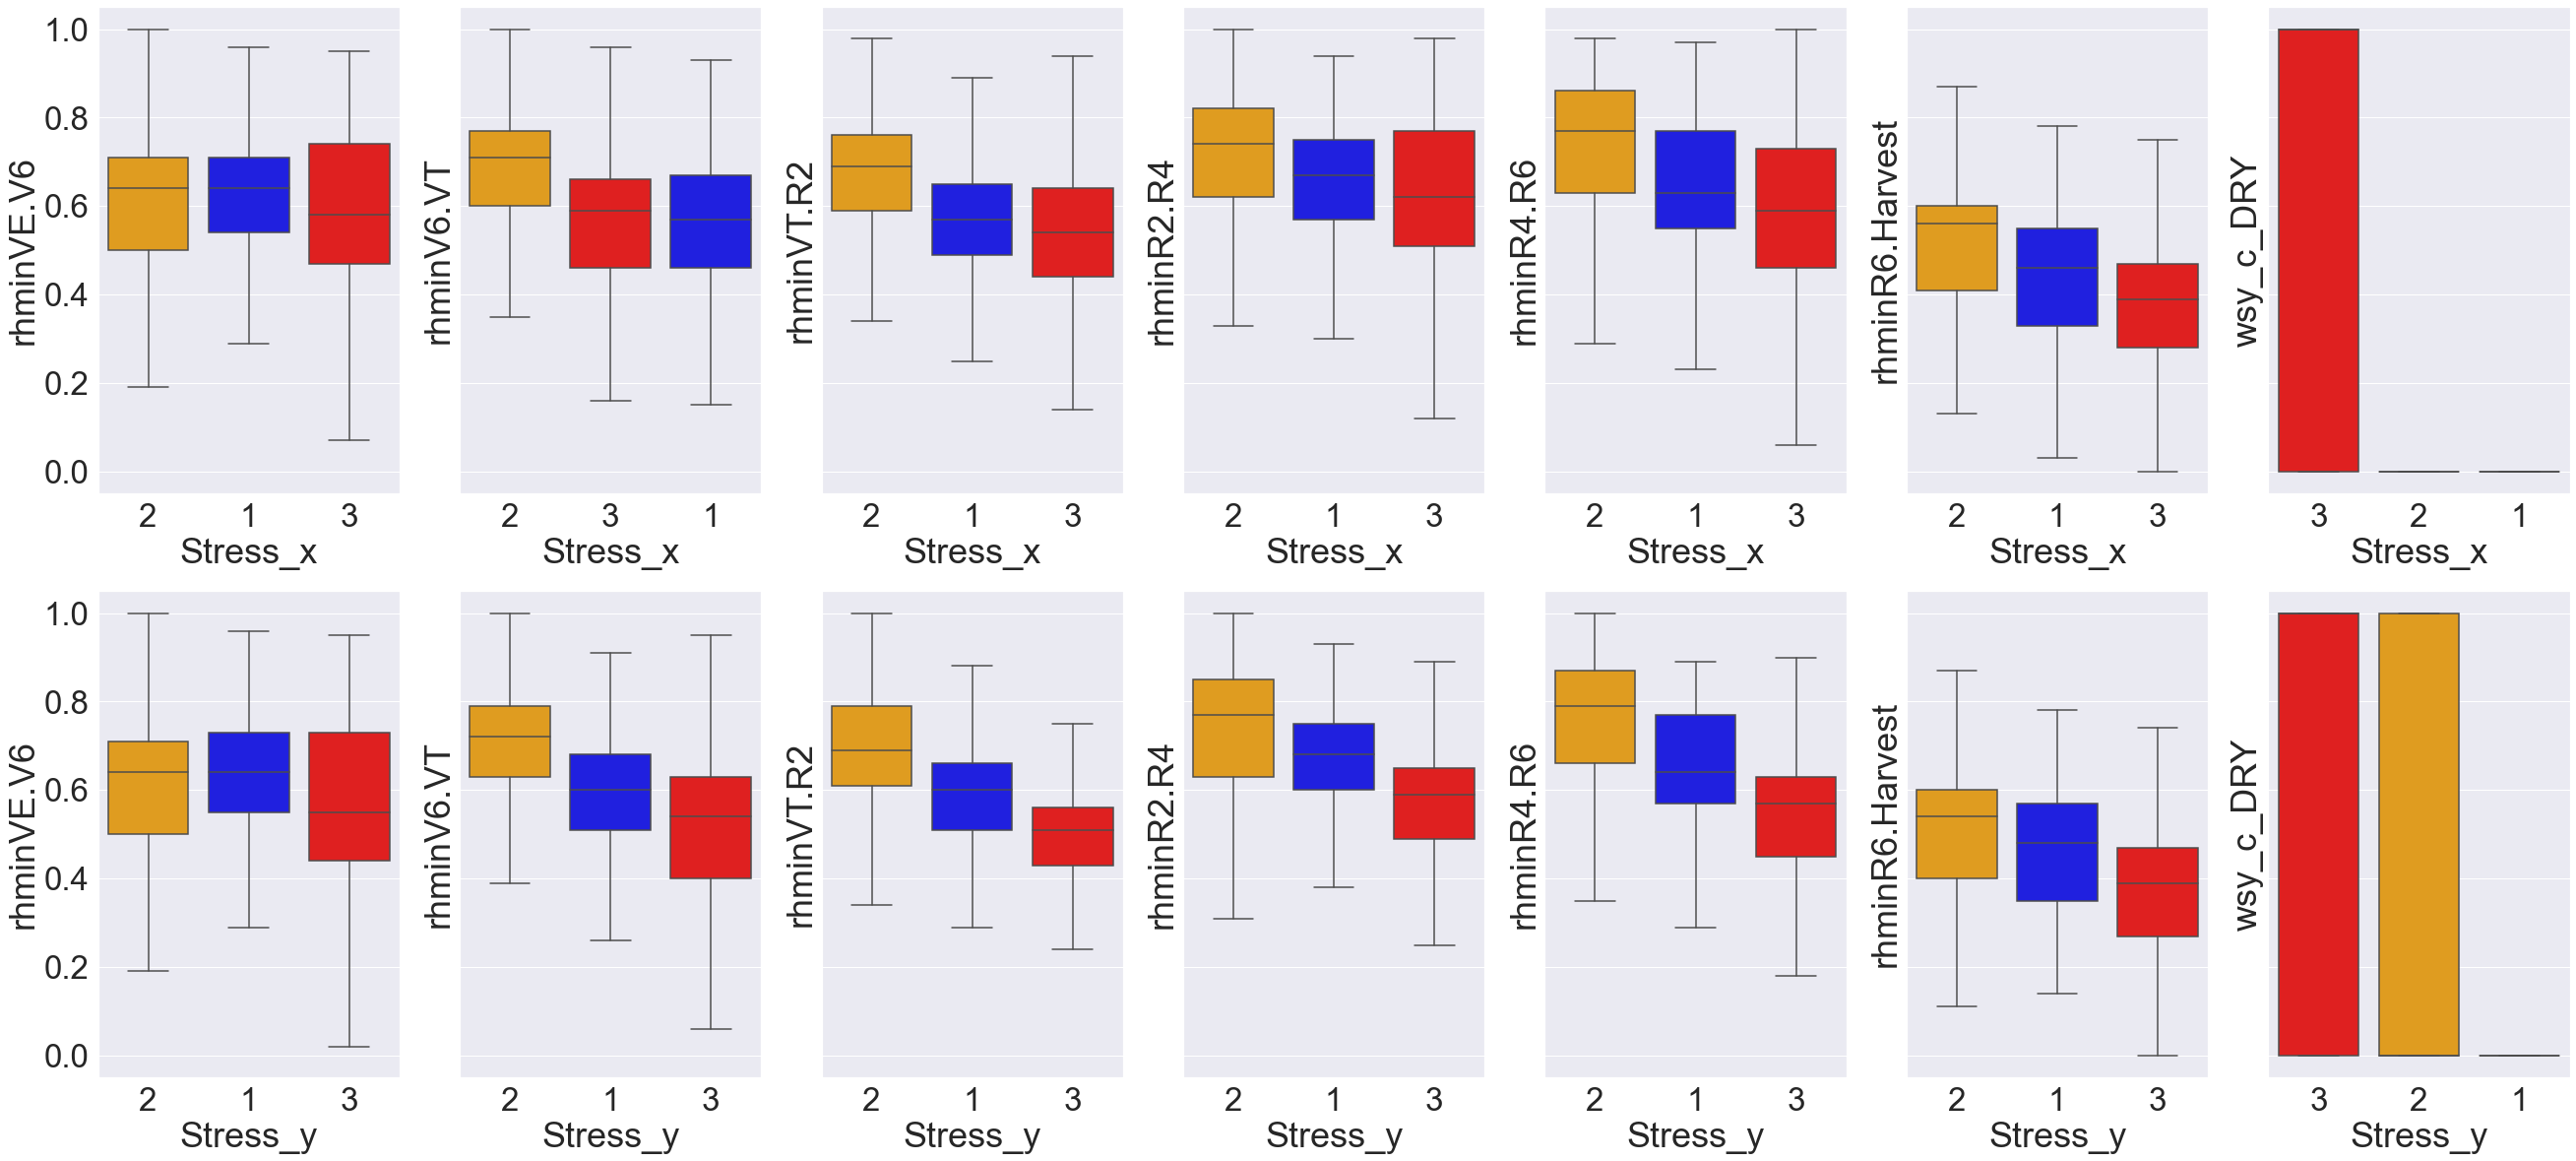

In [383]:
my_pal3 = {"High": "red", "Medium": "orange", "Low":"blue"}
my_pal3 = {3: "Red", 2: "orange", 1:'blue'}
sns.set(font_scale=3)
fig, ax = plt.subplots(2, 7,  sharey='row', figsize=(45, 20))
j = 42
for k in range(2):
    
    if k==0:
        ts= dh_class1.copy()
        ts['Stress_x'] = ts['dh_level1']
        my_order = ts.groupby(by=["Stress_x"])[ts.columns[j]].median().sort_values(ascending=False).index
        sns.boxplot(x=ts['Stress_x'], y=ts[ts.columns[j]],  ax=ax[k,0], showfliers = False, palette=my_pal3, order=my_order)

        my_order = ts.groupby(by=["Stress_x"])[ts.columns[j+1]].median().sort_values(ascending=False).index
        sns.boxplot(x=ts['Stress_x'], y=ts[ts.columns[j+1]],  ax=ax[k,1], showfliers = False, palette=my_pal3, order=my_order)

        my_order = ts.groupby(by=["Stress_x"])[ts.columns[j+2]].median().sort_values(ascending=False).index
        sns.boxplot(x=ts['Stress_x'], y=ts[ts.columns[j+2]],  ax=ax[k,2], showfliers = False, palette=my_pal3, order=my_order)

        my_order = ts.groupby(by=["Stress_x"])[ts.columns[j+3]].median().sort_values(ascending=False).index
        sns.boxplot(x=ts['Stress_x'], y=ts[ts.columns[j+3]],  ax=ax[k,3], showfliers = False, palette=my_pal3, order=my_order)
        
        my_order = ts.groupby(by=["Stress_x"])[ts.columns[j+4]].median().sort_values(ascending=False).index
        sns.boxplot(x=ts['Stress_x'], y=ts[ts.columns[j+4]],  ax=ax[k,4], showfliers = False, palette=my_pal3, order=my_order)

        my_order = ts.groupby(by=["Stress_x"])[ts.columns[j+5]].median().sort_values(ascending=False).index
        sns.boxplot(x=ts['Stress_x'], y=ts[ts.columns[j+5]],  ax=ax[k,5], showfliers = False, palette=my_pal3, order=my_order)
        
        my_order = ts.groupby(by=["Stress_x"])[ts.columns[j+6]].median().sort_values(ascending=False).index
        sns.boxplot(x=ts['Stress_x'], y=ts[ts.columns[j+6]],  ax=ax[k,6], showfliers = False, palette=my_pal3, order=my_order)


    else:
        ts= dh_class2.copy()
        ts['Stress_y'] = ts['dh_level2']
        my_order = ts.groupby(by=["Stress_y"])[ts.columns[j]].median().sort_values(ascending=False).index
        sns.boxplot(x=ts['Stress_y'], y=ts[ts.columns[j]],  ax=ax[k,0], showfliers = False, palette=my_pal3, order=my_order)

        my_order = ts.groupby(by=["Stress_y"])[ts.columns[j+1]].median().sort_values(ascending=False).index
        sns.boxplot(x=ts['Stress_y'], y=ts[ts.columns[j+1]],  ax=ax[k,1], showfliers = False, palette=my_pal3, order=my_order)

        my_order = ts.groupby(by=["Stress_y"])[ts.columns[j+2]].median().sort_values(ascending=False).index
        sns.boxplot(x=ts['Stress_y'], y=ts[ts.columns[j+2]],  ax=ax[k,2], showfliers = False, palette=my_pal3, order=my_order)

        my_order = ts.groupby(by=["Stress_y"])[ts.columns[j+3]].median().sort_values(ascending=False).index
        sns.boxplot(x=ts['Stress_y'], y=ts[ts.columns[j+3]],  ax=ax[k,3], showfliers = False, palette=my_pal3, order=my_order)
        
        my_order = ts.groupby(by=["Stress_y"])[ts.columns[j+4]].median().sort_values(ascending=False).index
        sns.boxplot(x=ts['Stress_y'], y=ts[ts.columns[j+4]],  ax=ax[k,4], showfliers = False, palette=my_pal3, order=my_order)

        my_order = ts.groupby(by=["Stress_y"])[ts.columns[j+5]].median().sort_values(ascending=False).index
        sns.boxplot(x=ts['Stress_y'], y=ts[ts.columns[j+5]],  ax=ax[k,5], showfliers = False, palette=my_pal3, order=my_order)
        
        my_order = ts.groupby(by=["Stress_y"])[ts.columns[j+6]].median().sort_values(ascending=False).index
        sns.boxplot(x=ts['Stress_y'], y=ts[ts.columns[j+6]],  ax=ax[k,6], showfliers = False, palette=my_pal3, order=my_order)

### Pairwise table 

In [ ]:
ts = pd.merge(dfs, dfs2, on=['WaterDeficitV6.VT', 'WaterDeficitVT.R2',
       'WaterDeficitR2.R4', 'WaterDeficitR4.R6',  
       'VaporPressureDeficitV6.VT', 'VaporPressureDeficitVT.R2',
       'VaporPressureDeficitR2.R4', 'VaporPressureDeficitR4.R6',
       'et0sumV6.VT','et0sumVT.R2', 'et0sumR2.R4', 'et0sumR4.R6', 'rhavgV6.VT', 'rhavgVT.R2', 'rhavgR2.R4', 'rhavgR4.R6',
        'HPRV6.VT', 'HPRVT.R2', 'HPRR2.R4',
       'HPRR4.R6', 'tempavgV6.VT',
       'tempavgVT.R2', 'tempavgR2.R4', 'tempavgR4.R6', 'precsumV6.VT', 'precsumVT.R2', 'precsumR2.R4',
       'precsumR4.R6',   'WaterDeficitVE.V6'])

In [ ]:
ts.groupby(['Stress_x','Stress_y']).size()

### PCA visualization 

In [ ]:
dt_x1 = dfs1b[['WaterDeficitV6-VT', 'WaterDeficitVT-R2',
       'WaterDeficitR2-R4', 'WaterDeficitR4-R6',
       'VaporPressureDeficitV6-VT', 'VaporPressureDeficitVT-R2',
       'VaporPressureDeficitR2-R4', 'VaporPressureDeficitR4-R6', 'rhavgV6-VT', 'rhavgVT-R2', 'rhavgR2-R4', 'rhavgR4-R6',
       'HPRV6-VT', 'HPRVT-R2', 'HPRR2-R4',
       'HPRR4-R6',   'precsumV6-VT', 'precsumVT-R2', 'precsumR2-R4',
       'precsumR4-R6']]
dt_x1 = pd.get_dummies(dt_x1)

#dfs2 = dfs.copy()
dt_x2 = dfs2b[['WaterDeficitV6-VT', 'WaterDeficitVT-R2',
       'WaterDeficitR2-R4', 'WaterDeficitR4-R6',
       'VaporPressureDeficitV6-VT', 'VaporPressureDeficitVT-R2',
       'VaporPressureDeficitR2-R4', 'VaporPressureDeficitR4-R6', 'rhavgV6-VT', 'rhavgVT-R2', 'rhavgR2-R4', 'rhavgR4-R6',
       'HPRV6-VT', 'HPRVT-R2', 'HPRR2-R4',
       'HPRR4-R6',   'precsumV6-VT', 'precsumVT-R2', 'precsumR2-R4',
       'precsumR4-R6']]
dt_x2 = pd.get_dummies(dt_x2)

In [ ]:
X1 = StandardScaler().fit_transform(dt_x1)
pca = PCA(n_components=5).fit(X1)
dt_pca1 = pca.transform(X1)
pca_df1 = pd.DataFrame(dt_pca1,columns=['P1','P2','P3',"P4",'P5'])
print(pca.explained_variance_ratio_)

X2 = StandardScaler().fit_transform(dt_x2)
pca = PCA(n_components=5).fit(X2)
dt_pca2 = pca.transform(X2)
pca_df2 = pd.DataFrame(dt_pca2,columns=['P1','P2','P3',"P4",'P5'])
print(pca.explained_variance_ratio_)

In [ ]:
sns.scatterplot(x='P1',y='P3', hue=dfs1b['Stress'],  palette=my_pal3, data=pca_df1)
plt.show()

In [ ]:
sns.scatterplot(x='P1',y='P3', hue=dfs2b['Stress'],  palette=my_pal3, data=pca_df2)
plt.show()

# Pie plot 

In [ ]:
dfs['year'].value_counts()

In [ ]:
def my_fmt(x):
    print(x)
    return '{:.0f}%\n({:.0f})'.format(x, dfs.shape[0]*x/100)

def my_fmt(x):
    print(x)
    return '{:.0f}%'.format(x, dfs.shape[0]*x/100)

In [ ]:
dfs['Stress'].loc[dfs.Stress==1] = 'Low'
dfs['Stress'].loc[dfs.Stress==2] = 'Medium'
dfs['Stress'].loc[dfs.Stress==3] = 'High'

In [ ]:
from jupyterthemes import jtplot

# you can select an alternative theme's plot style by name
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style('monokai')

In [ ]:
dfs.groupby(['wsy_c','Stress']).size()

In [ ]:
wms[0]

In [ ]:
per_df

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(18, 12))
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
wms = dfs['wsy_c'].unique()

for i in range(3):
   
    dt = dfs.loc[dfs.wsy_c==wms[i]]
    
    per = dt.groupby(['Stress']).size()
    per_df = pd.DataFrame(per)
    per_df.rename(columns={0:'Count'}, inplace=True)
    per_df = per_df.reset_index()
    per_df['Color']='orange'
    per_df['Color'].loc[per_df.Stress=='Low']='blue'
    per_df['Color'].loc[per_df.Stress=='High']='red'
    labels = per_df['Stress']
    per = per_df['Count']
    cor = per_df['Color']
    
    lb = wms[i]
    axes[i].pie(per, labels=labels, colors= cor, autopct=my_fmt)
    axes[i].set_title(lb, color='blue')

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
sns.set(font_scale = 2)
plt.style.use('seaborn-white')

for i in range(11):
    year = 2011 + i
    
    dt = dfs.loc[dfs.year==year]
    
    per = dt.groupby(['Stress']).size()
    per_df = pd.DataFrame(per)
    per_df.rename(columns={0:'Count'}, inplace=True)
    per_df = per_df.reset_index()
    per_df['Color']='orange'
    per_df['Color'].loc[per_df.Stress=='Low']='blue'
    per_df['Color'].loc[per_df.Stress=='High']='red'
    labels = per_df['Stress']
    per = per_df['Count']
    cor = per_df['Color']
    
    y = i%4
    x = i//4
   
    lb = 'Year: ' + str(year)
    axes[x,y].pie(per, labels=labels, colors= cor, autopct=my_fmt)
    axes[x,y].set_title(lb, color='blue')

fig.delaxes(axes[2][3])

# Others

## Test use how many clusters 

In [ ]:
def clustering_eva(drought_heat, pred_gap, dt_y, ncluster= 30, rep= 5):
    
    dis_df = pd.DataFrame()
    db_df = pd.DataFrame()
    ch_df = pd.DataFrame()
    ct_low_df = pd.DataFrame()
    ct_high_df = pd.DataFrame()
    
    for i in range(rep):
        
        dh_variables = drought_heat.loc[:,round(drought_heat.std(axis=0),5)>0]
        dh_cp = FactorAnalyzer(n_factors=40, rotation="varimax", method="principal",  is_corr_matrix=False).fit(dh_variables)
        dh_fac = pd.DataFrame(dh_cp.transform(dh_variables))
    
        clu_li = var_imp_cluster_li(dh_fac, dt_y,n_cluster=ncluster)
        clu_rf = var_imp_cluster_rf(dh_fac, dt_y,n_cluster=ncluster)
        
        
        dh_var2 = dh_fac.copy()
        dh_var2['pred_gap'] = pred_gap
        dh_var2['pred_gap'] = dh_var2['pred_gap'].round(0)

        dh_var2['cluster_li'] = clu_li
        dh_var2['cluster_rf'] = clu_rf
       
        dh_class_li= dh_var2.groupby(['cluster_li']).agg('median').sort_values(['pred_gap'])
        dh_class_li = dh_class_li.reset_index()
        dh_class_li['dh_level_li']=3
        dh_class_li['dh_level_li'].loc[dh_class_li['pred_gap']>(-20)]=2
        dh_class_li['dh_level_li'].loc[dh_class_li['pred_gap']>(0)]=1
        dh_var2a = pd.merge(dh_var2, dh_class_li[['cluster_li','dh_level_li']], on=['cluster_li'], how='left')

        dh_class_rf= dh_var2.groupby(['cluster_rf']).agg('median').sort_values(['pred_gap'])
        dh_class_rf = dh_class_rf.reset_index()
        dh_class_rf['dh_level_rf']=3
        dh_class_rf['dh_level_rf'].loc[dh_class_rf['pred_gap']>(-20)]=2
        dh_class_rf['dh_level_rf'].loc[dh_class_rf['pred_gap']>(0)]=1
        dh_var2b= pd.merge(dh_var2a, dh_class_rf[['cluster_rf','dh_level_rf']], on=['cluster_rf'], how='left')

       
        dh_variables = drought_heat.loc[:,round(drought_heat.std(axis=0),5)>0]
        dh_cp = FactorAnalyzer(n_factors=40, rotation="varimax", method="principal",  is_corr_matrix=False).fit(dh_variables)
        dh_fac = pd.DataFrame(dh_cp.transform(dh_variables))
        
        li_dis = metrics.silhouette_score(dh_fac, dh_var2b['dh_level_li'])
        rf_dis = metrics.silhouette_score(dh_fac, dh_var2b['dh_level_rf'])
       
        li_ch = metrics.calinski_harabasz_score(dh_fac, dh_var2b['dh_level_li'])
        rf_ch = metrics.calinski_harabasz_score(dh_fac, dh_var2b['dh_level_rf'])
        
        li_db = metrics.davies_bouldin_score(dh_fac, dh_var2b['dh_level_li'])
        rf_db = metrics.davies_bouldin_score(dh_fac, dh_var2b['dh_level_rf'])
        
        li_hg = dh_var2b.loc[dh_var2b['dh_level_li']==3].shape[0]
        li_lw = dh_var2b.loc[dh_var2b['dh_level_li']==1].shape[0]
        rf_hg = dh_var2b.loc[dh_var2b['dh_level_rf']==3].shape[0]
        rf_lw = dh_var2b.loc[dh_var2b['dh_level_rf']==1].shape[0]
        
        dis = [li_dis, rf_dis]
        ch = [li_ch, rf_ch]
        db = [li_db, rf_db]
        
        ct_low = [li_lw, rf_lw]
        ct_high = [li_hg, rf_hg]

        dis = pd.DataFrame(dis).T
        ch = pd.DataFrame(ch).T
        db = pd.DataFrame(db).T
        ct_low = pd.DataFrame(ct_low).T
        ct_high = pd.DataFrame(ct_high).T
        
        dis_df = pd.concat([dis_df, dis])
        db_df = pd.concat([db_df, db])
        ch_df = pd.concat([ch_df, ch])
        ct_low_df = pd.concat([ct_low_df, ct_low])
        ct_high_df = pd.concat([ct_high_df, ct_high])
        
    dis_df.columns = ch_df.columns = db_df.columns = ct_low_df.columns = ct_high_df.columns= ['Linear','RF']
    return dis_df, ch_df, db_df, ct_low_df, ct_high_df


In [ ]:
cls = [10,20,30,40,50]
dta_all= pd.DataFrame()

for cl in cls:
    dis_df, ch_df, db_df, ct_low_df, ct_high_df = clustering_eva(drought_heat, lr_pred, dt_y, ncluster= cl, rep= 5)
    dis_df['metric']='dis'
    ch_df['metric'] = 'ch'
    db_df['metric'] = 'db'
    ct_low_df['metric'] = 'count_low'
    ct_high_df['metric'] = 'count_high'
    dta_df = pd.concat([dis_df, ch_df, db_df, ct_low_df, ct_high_df], axis=0)
    dta_df['n_cluster'] = cl
    dta_all.columns = dta_df.columns
    dta_all = pd.concat([dta_all, dta_df], axis=0)


## Test which weight model 

In [233]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [277]:
def clustering_eva(drought_heat, pred_gap, dt_y, ncluster= 30, rep= 10):
    
    dis_df = pd.DataFrame()
    db_df = pd.DataFrame()
    ch_df = pd.DataFrame()
    ct_low_df = pd.DataFrame()
    ct_high_df = pd.DataFrame()
    
    for i in range(rep):
        
        dh_variables = drought_heat.loc[:,round(drought_heat.std(axis=0),5)>0]
        dh_cp = FactorAnalyzer(n_factors=40, rotation="varimax", method="principal",  is_corr_matrix=False).fit(dh_variables)
        dh_fac = pd.DataFrame(dh_cp.transform(dh_variables))
    
        clu_li = var_imp_cluster_li(dh_fac, dt_y,n_cluster=ncluster)
        clu_rf = var_imp_cluster_rf(dh_fac, dt_y,n_cluster=ncluster)
        
        
        dh_var2 = dh_fac.copy()
        dh_var2['pred_gap'] = pred_gap
        dh_var2['pred_gap'] = dh_var2['pred_gap'].round(0)

        dh_var2['cluster_li'] = clu_li
        dh_var2['cluster_rf'] = clu_rf
       
        dh_class_li= dh_var2.groupby(['cluster_li']).agg('median').sort_values(['pred_gap'])
        dh_class_li = dh_class_li.reset_index()
        dh_class_li['dh_level_li']=3
        dh_class_li['dh_level_li'].loc[dh_class_li['pred_gap']>(-20)]=2
        dh_class_li['dh_level_li'].loc[dh_class_li['pred_gap']>(0)]=1
        dh_var2a = pd.merge(dh_var2, dh_class_li[['cluster_li','dh_level_li']], on=['cluster_li'], how='left')

        dh_class_rf= dh_var2.groupby(['cluster_rf']).agg('median').sort_values(['pred_gap'])
        dh_class_rf = dh_class_rf.reset_index()
        dh_class_rf['dh_level_rf']=3
        dh_class_rf['dh_level_rf'].loc[dh_class_rf['pred_gap']>(-20)]=2
        dh_class_rf['dh_level_rf'].loc[dh_class_rf['pred_gap']>(0)]=1
        dh_var2b= pd.merge(dh_var2a, dh_class_rf[['cluster_rf','dh_level_rf']], on=['cluster_rf'], how='left')

       
        dh_variables = drought_heat.loc[:,round(drought_heat.std(axis=0),5)>0]
        dh_cp = FactorAnalyzer(n_factors=40, rotation="varimax", method="principal",  is_corr_matrix=False).fit(dh_variables)
        dh_fac = pd.DataFrame(dh_cp.transform(dh_variables))
        
        li_dis = metrics.silhouette_score(dh_fac, dh_var2b['dh_level_li'])
        rf_dis = metrics.silhouette_score(dh_fac, dh_var2b['dh_level_rf'])
       
        li_ch = metrics.calinski_harabasz_score(dh_fac, dh_var2b['dh_level_li'])
        rf_ch = metrics.calinski_harabasz_score(dh_fac, dh_var2b['dh_level_rf'])
        
        li_db = metrics.davies_bouldin_score(dh_fac, dh_var2b['dh_level_li'])
        rf_db = metrics.davies_bouldin_score(dh_fac, dh_var2b['dh_level_rf'])
        
        li_hg = dh_var2b.loc[dh_var2b['dh_level_li']==3].shape[0]
        li_lw = dh_var2b.loc[dh_var2b['dh_level_li']==1].shape[0]
        rf_hg = dh_var2b.loc[dh_var2b['dh_level_rf']==3].shape[0]
        rf_lw = dh_var2b.loc[dh_var2b['dh_level_rf']==1].shape[0]
        
        dis = [li_dis, rf_dis]
        ch = [li_ch, rf_ch]
        db = [li_db, rf_db]
        
        ct_low = [li_lw, rf_lw, nvs_nwt_lw, nwt_lw]
        ct_high = [li_hg, rf_hg, nvs_nwt_hg, nwt_hg]

        dis = pd.DataFrame(dis).T
        ch = pd.DataFrame(ch).T
        db = pd.DataFrame(db).T
        ct_low = pd.DataFrame(ct_low).T
        ct_high = pd.DataFrame(ct_high).T
        
        dis_df = pd.concat([dis_df, dis])
        db_df = pd.concat([db_df, db])
        ch_df = pd.concat([ch_df, ch])
        ct_low_df = pd.concat([ct_low_df, ct_low])
        ct_high_df = pd.concat([ct_high_df, ct_high])
        
    dis_df.columns = ch_df.columns = db_df.columns = ct_low_df.columns = ct_high_df.columns= ['Linear','RF']
    return dis_df, ch_df, db_df, ct_low_df, ct_high_df

### Define function 

In [ ]:
def clustering_eva(drought_heat, pred_gap, dt_y, ncluster= 30, rep= 10):
    
    dis_df = pd.DataFrame()
    db_df = pd.DataFrame()
    ch_df = pd.DataFrame()
    for i in range(rep):
        
        dh_variables = drought_heat.loc[:,round(drought_heat.std(axis=0),5)>0]
        dh_cp = FactorAnalyzer(n_factors=40, rotation="varimax", method="principal",  is_corr_matrix=False).fit(dh_variables)
        dh_fac = pd.DataFrame(dh_cp.transform(dh_variables))
    
        clu_li = var_imp_cluster_li(dh_fac, dt_y,n_cluster=ncluster)
        clu_rf = var_imp_cluster_rf(dh_fac, dt_y,n_cluster=ncluster)
        clu_nvs_nwt = var_imp_cluster_nvs_nwt(dh_fac, dt_y,n_cluster=ncluster)
        clu_nwt = var_imp_cluster_nwt(dh_fac, dt_y,n_cluster=ncluster)
        
        dh_var2 = dh_fac.copy()
        dh_var2['pred_gap'] = pred_gap
        dh_var2['pred_gap'] = dh_var2['pred_gap'].round(0)

        dh_var2['cluster_li'] = clu_li
        dh_var2['cluster_rf'] = clu_rf
        dh_var2['cluster_nvs_nwt'] = clu_nvs_nwt
        dh_var2['cluster_nwt'] = clu_nwt

        dh_class_li= dh_var2.groupby(['cluster_li']).agg('median').sort_values(['pred_gap'])
        dh_class_li = dh_class_li.reset_index()
        dh_class_li['dh_level_li']=3
        dh_class_li['dh_level_li'].loc[dh_class_li['pred_gap']>(-20)]=2
        dh_class_li['dh_level_li'].loc[dh_class_li['pred_gap']>(0)]=1
        dh_var2a = pd.merge(dh_var2, dh_class_li[['cluster_li','dh_level_li']], on=['cluster_li'], how='left')

        dh_class_rf= dh_var2.groupby(['cluster_rf']).agg('median').sort_values(['pred_gap'])
        dh_class_rf = dh_class_rf.reset_index()
        dh_class_rf['dh_level_rf']=3
        dh_class_rf['dh_level_rf'].loc[dh_class_rf['pred_gap']>(-20)]=2
        dh_class_rf['dh_level_rf'].loc[dh_class_rf['pred_gap']>(0)]=1
        dh_var2b= pd.merge(dh_var2a, dh_class_rf[['cluster_rf','dh_level_rf']], on=['cluster_rf'], how='left')

        dh_class_nvs_nwt= dh_var2.groupby(['cluster_nvs_nwt']).agg('median').sort_values(['pred_gap'])
        dh_class_nvs_nwt = dh_class_nvs_nwt.reset_index()
        dh_class_nvs_nwt['dh_level_nvs_nwt']=3
        dh_class_nvs_nwt['dh_level_nvs_nwt'].loc[dh_class_nvs_nwt['pred_gap']>(-20)]=2
        dh_class_nvs_nwt['dh_level_nvs_nwt'].loc[dh_class_nvs_nwt['pred_gap']>(0)]=1
        dh_var2c= pd.merge(dh_var2b, dh_class_nvs_nwt[['cluster_nvs_nwt','dh_level_nvs_nwt']], on=['cluster_nvs_nwt'], how='left')

        dh_class_nwt= dh_var2.groupby(['cluster_nwt']).agg('median').sort_values(['pred_gap'])
        dh_class_nwt = dh_class_nwt.reset_index()
        dh_class_nwt['dh_level_nwt']=3
        dh_class_nwt['dh_level_nwt'].loc[dh_class_nwt['pred_gap']>(-20)]=2
        dh_class_nwt['dh_level_nwt'].loc[dh_class_nwt['pred_gap']>(0)]=1
        dh_var2d= pd.merge(dh_var2c, dh_class_nwt[['cluster_nwt','dh_level_nwt']], on=['cluster_nwt'], how='left')

        dh_variables = drought_heat.loc[:,round(drought_heat.std(axis=0),5)>0]
        dh_cp = FactorAnalyzer(n_factors=40, rotation="varimax", method="principal",  is_corr_matrix=False).fit(dh_variables)
        dh_fac = pd.DataFrame(dh_cp.transform(dh_variables))
        
        li_dis = metrics.silhouette_score(dh_fac, dh_var2d['dh_level_li'])
        rf_dis = metrics.silhouette_score(dh_fac, dh_var2d['dh_level_rf'])
        nvs_nwt_dis = metrics.silhouette_score(dh_fac, dh_var2d['dh_level_nvs_nwt'])
        nwt_dis = metrics.silhouette_score(dh_fac, dh_var2d['dh_level_nwt'])

        li_ch = metrics.calinski_harabasz_score(dh_fac, dh_var2d['dh_level_li'])
        rf_ch = metrics.calinski_harabasz_score(dh_fac, dh_var2d['dh_level_rf'])
        nvs_nwt_ch = metrics.calinski_harabasz_score(dh_fac, dh_var2d['dh_level_nvs_nwt'])
        nwt_ch = metrics.calinski_harabasz_score(dh_fac, dh_var2d['dh_level_nwt'])

        li_db = metrics.davies_bouldin_score(dh_fac, dh_var2d['dh_level_li'])
        rf_db = metrics.davies_bouldin_score(dh_fac, dh_var2d['dh_level_rf'])
        nvs_nwt_db = metrics.davies_bouldin_score(dh_fac, dh_var2d['dh_level_nvs_nwt'])
        nwt_db = metrics.davies_bouldin_score(dh_fac, dh_var2d['dh_level_nwt'])

        dis = [li_dis, rf_dis, nvs_nwt_dis, nwt_dis]
        ch = [li_ch, rf_ch, nvs_nwt_ch, nwt_ch]
        db = [li_db, rf_db, nvs_nwt_db, nwt_db]

        dis = pd.DataFrame(dis).T
        ch = pd.DataFrame(ch).T
        db = pd.DataFrame(db).T
        dis_df = pd.concat([dis_df, dis])
        db_df = pd.concat([db_df, db])
        ch_df = pd.concat([ch_df, ch])
        
    dis_df.columns = ch_df.columns = db_df.columns = ['Linear','RF','nvs_nwt','nwt']
    return dis_df, ch_df, db_df

### Run characterization multiple times 

In [ ]:
dis_df, ch_df, db_df = clustering_eva(drought_heat, lr_pred, dt_y, ncluster= 30, rep= 2)
print(dis_df.describe().round(2))
print(ch_df.describe().round(2))
print(db_df.describe().round(2))

### Old code for 1 evaluation 

#### Clustering 

In [ ]:
clu_li = var_imp_cluster_li(dh_fac, dt_y,n_cluster=30)
clu_rf = var_imp_cluster_rf(dh_fac, dt_y,n_cluster=30)
clu_nvs_nwt = var_imp_cluster_nvs_nwt(dh_fac, dt_y,n_cluster=30)
clu_nwt = var_imp_cluster_nwt(dh_fac, dt_y,n_cluster=30)

#### Evaluate on factors 

In [ ]:
dh_var2 = dh_fac.copy()
dh_var2[['YGSMN']] = dta3[['YGSMN']]
dh_var2['pred_gap'] = lr_pred
dh_var2['pred_gap'] = dh_var2['pred_gap'].round(0)

dh_var2['cluster_li'] = clu_li
dh_var2['cluster_rf'] = clu_rf
dh_var2['cluster_nvs_nwt'] = clu_nvs_nwt
dh_var2['cluster_nwt'] = clu_nwt

dh_class_li= dh_var2.groupby(['cluster_li']).agg('median').sort_values(['pred_gap'])
dh_class_li = dh_class_li.reset_index()
dh_class_li['dh_level_li']=3
dh_class_li['dh_level_li'].loc[dh_class_li['pred_gap']>(-20)]=2
dh_class_li['dh_level_li'].loc[dh_class_li['pred_gap']>(0)]=1
dh_var2a = pd.merge(dh_var2, dh_class_li[['cluster_li','dh_level_li']], on=['cluster_li'], how='left')

dh_class_rf= dh_var2.groupby(['cluster_rf']).agg('median').sort_values(['pred_gap'])
dh_class_rf = dh_class_rf.reset_index()
dh_class_rf['dh_level_rf']=3
dh_class_rf['dh_level_rf'].loc[dh_class_rf['pred_gap']>(-20)]=2
dh_class_rf['dh_level_rf'].loc[dh_class_rf['pred_gap']>(0)]=1
dh_var2b= pd.merge(dh_var2a, dh_class_rf[['cluster_rf','dh_level_rf']], on=['cluster_rf'], how='left')

dh_class_nvs_nwt= dh_var2.groupby(['cluster_nvs_nwt']).agg('median').sort_values(['pred_gap'])
dh_class_nvs_nwt = dh_class_nvs_nwt.reset_index()
dh_class_nvs_nwt['dh_level_nvs_nwt']=3
dh_class_nvs_nwt['dh_level_nvs_nwt'].loc[dh_class_nvs_nwt['pred_gap']>(-20)]=2
dh_class_nvs_nwt['dh_level_nvs_nwt'].loc[dh_class_nvs_nwt['pred_gap']>(0)]=1
dh_var2c= pd.merge(dh_var2b, dh_class_nvs_nwt[['cluster_nvs_nwt','dh_level_nvs_nwt']], on=['cluster_nvs_nwt'], how='left')

dh_class_nwt= dh_var2.groupby(['cluster_nwt']).agg('median').sort_values(['pred_gap'])
dh_class_nwt = dh_class_nwt.reset_index()
dh_class_nwt['dh_level_nwt']=3
dh_class_nwt['dh_level_nwt'].loc[dh_class_nwt['pred_gap']>(-20)]=2
dh_class_nwt['dh_level_nwt'].loc[dh_class_nwt['pred_gap']>(0)]=1
dh_var2d= pd.merge(dh_var2c, dh_class_nwt[['cluster_nwt','dh_level_nwt']], on=['cluster_nwt'], how='left')

print(dh_var2d['dh_level_li'].value_counts())
print(dh_var2d['dh_level_rf'].value_counts())
print(dh_var2d['dh_level_nwt'].value_counts())
print(dh_var2d['dh_level_nvs_nwt'].value_counts())

In [ ]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
dh_var3 = dh_fac.copy()
#dh_var3 = dh_var2d[['YGSMN']]

li_dis = metrics.silhouette_score(dh_var3, dh_var2d['dh_level_li'])
rf_dis = metrics.silhouette_score(dh_var3, dh_var2d['dh_level_rf'])
nvs_nwt_dis = metrics.silhouette_score(dh_var3, dh_var2d['dh_level_nvs_nwt'])
nwt_dis = metrics.silhouette_score(dh_var3, dh_var2d['dh_level_nwt'])

li_ch = metrics.calinski_harabasz_score(dh_var3, dh_var2d['dh_level_li'])
rf_ch = metrics.calinski_harabasz_score(dh_var3, dh_var2d['dh_level_rf'])
nvs_nwt_ch = metrics.calinski_harabasz_score(dh_var3, dh_var2d['dh_level_nvs_nwt'])
nwt_ch = metrics.calinski_harabasz_score(dh_var3, dh_var2d['dh_level_nwt'])

li_db = metrics.davies_bouldin_score(dh_var3, dh_var2d['dh_level_li'])
rf_db = metrics.davies_bouldin_score(dh_var3, dh_var2d['dh_level_rf'])
nvs_nwt_db = metrics.davies_bouldin_score(dh_var3, dh_var2d['dh_level_nvs_nwt'])
nwt_db = metrics.davies_bouldin_score(dh_var3, dh_var2d['dh_level_nwt'])

In [ ]:
li_dis, rf_dis, nvs_nwt_dis, nwt_dis

li_ch, rf_ch, nvs_nwt_ch, nwt_ch

li_db, rf_db, nvs_nwt_db, nwt_db

#### Evaluate on YGSMN

In [ ]:
dh_var3 = dh_var2d[['YGSMN']]

li_dis = metrics.silhouette_score(dh_var3, dh_var2d['dh_level_li'])
rf_dis = metrics.silhouette_score(dh_var3, dh_var2d['dh_level_rf'])
nvs_nwt_dis = metrics.silhouette_score(dh_var3, dh_var2d['dh_level_nvs_nwt'])
nwt_dis = metrics.silhouette_score(dh_var3, dh_var2d['dh_level_nwt'])

li_ch = metrics.calinski_harabasz_score(dh_var3, dh_var2d['dh_level_li'])
rf_ch = metrics.calinski_harabasz_score(dh_var3, dh_var2d['dh_level_rf'])
nvs_nwt_ch = metrics.calinski_harabasz_score(dh_var3, dh_var2d['dh_level_nvs_nwt'])
nwt_ch = metrics.calinski_harabasz_score(dh_var3, dh_var2d['dh_level_nwt'])

li_db = metrics.davies_bouldin_score(dh_var3, dh_var2d['dh_level_li'])
rf_db = metrics.davies_bouldin_score(dh_var3, dh_var2d['dh_level_rf'])
nvs_nwt_db = metrics.davies_bouldin_score(dh_var3, dh_var2d['dh_level_nvs_nwt'])
nwt_db = metrics.davies_bouldin_score(dh_var3, dh_var2d['dh_level_nwt'])

li_dis, rf_dis, nvs_nwt_dis, nwt_dis

li_ch, rf_ch, nvs_nwt_ch, nwt_ch

li_db, rf_db, nvs_nwt_db, nwt_db

## Previous stress results 

In [ ]:
stre = pd.read_csv('DH_stress_3_levels_All_market_segs_2016_2021.csv')
dt_stress = pd.merge(dta, stre, on=['trial_id'])
wsy_dt = pd.get_dummies(dta[['wsy_c']])
dt_stress = pd.concat([dt_stress, wsy_dt], axis=1)
dt_y = dt_stress[['Stress']]
dt_x = dt_stress[drought_heat.columns.to_list()]

print(dt_x.shape)
print(dt_y.shape)

dt_xy = pd.concat([dt_x, dt_y], axis=1)
dt_xy = dt_xy.drop_duplicates()
dt_xy = dt_xy.dropna()
dt_xy.shape

dt_xy['Stress'].loc[dt_xy['Stress']=='Low']=1
dt_xy['Stress'].loc[dt_xy['Stress']=='Medium']=2
dt_xy['Stress'].loc[dt_xy['Stress']=='High']=3
dt_xy['Stress'] =  dt_xy['Stress'].astype(int)
dt_y = dt_xy['Stress']
dt_x = dt_xy[drought_heat.columns.to_list()]

print(dt_x.shape)
print(dt_y.shape)

fea_tr, fea_ts, y_tr, y_ts = train_test_split(dt_x, dt_y, test_size=0.15, random_state=6)
rf = RandomForestClassifier(n_estimators=100, n_jobs=6)
rf.fit(fea_tr, y_tr)
    
rf_pred = rf.predict(fea_ts)
print(sklearn.metrics.balanced_accuracy_score(y_ts, rf_pred))

y_pred = pd.DataFrame(rf.predict(dt_x))
dt_y2 = pd.DataFrame(dt_y)
y_pred.index = dt_y2.index
y_all = pd.concat([y_pred, dt_y2], axis=1)
y_all.columns = ['Stress_pred','Stress']
y_all.groupby(['Stress_pred','Stress']).size()

## Integrate environment data and YGSMN data

In [ ]:
os.chdir('C:/Users/s1052014/OneDrive - Syngenta/Desktop/NA_corn_WO/Data2021/Drought Stress/corn dataset')
#pheno = pd.read_csv('NEW_2016to2021_Pheno_UPDATED.csv')
dt12 = pd.read_csv('YGSMN_Trial_id.csv')
#env = pd.read_csv('Environment_data_2016_2021.csv')
env = pd.read_csv('Environment_variables_2009_2021_Feb_2022.csv')
print(env.shape)
dt = pd.merge(env, dt12, on=['trial_id'])
dt.shape

dt['HPR30DBP.Planting'] = dt['tempavg30DBP.Planting']/dt['precsum30DBP.Planting']
dt['HPRPlanting.VE'] = dt['tempavgPlanting.VE']/dt['precsumPlanting.VE']
dt['HPRVE.V6'] = dt['tempavgVE.V6']/dt['precsumVE.V6']
dt['HPRV6.VT'] = dt['tempavgV6.VT']/dt['precsumV6.VT']
dt['HPRVT.R2'] = dt['tempavgVT.R2']/dt['precsumVT.R2']
dt['HPRR2.R4'] = dt['tempavgR2.R4']/dt['precsumR2.R4']
dt['HPRR4.R6'] = dt['tempavgR4.R6']/dt['precsumR4.R6']
dt['HPRR6.Harvest'] = dt['tempavgR6.Harvest']/dt['precsumR6.Harvest']
dt['HPR30DBP.Planting'].loc[dt['HPR30DBP.Planting']>10] = 10
dt['HPR30DBP.Planting'].loc[dt['HPR30DBP.Planting']<0] = 0
dt['HPRPlanting.VE'].loc[dt['HPRPlanting.VE']>10] = 10
dt['HPRPlanting.VE'].loc[dt['HPRPlanting.VE']<0] = 0
dt['HPRVE.V6'].loc[dt['HPRVE.V6']>10] = 10
dt['HPRVE.V6'].loc[dt['HPRVE.V6']<0] = 0
dt['HPRV6.VT'].loc[dt['HPRV6.VT']>10] = 10
dt['HPRV6.VT'].loc[dt['HPRV6.VT']<0] = 0
dt['HPRVT.R2'].loc[dt['HPRVT.R2']>10] = 10
dt['HPRVT.R2'].loc[dt['HPRVT.R2']<0] = 0
dt['HPRR2.R4'].loc[dt['HPRR2.R4']>10] = 10
dt['HPRR2.R4'].loc[dt['HPRR2.R4']<0] = 0
dt['HPRR4.R6'].loc[dt['HPRR4.R6']>10] = 10
dt['HPRR4.R6'].loc[dt['HPRR4.R6']<0] = 0
dt['HPRR6.Harvest'].loc[dt['HPRR6.Harvest']>10] = 10
dt['HPRR6.Harvest'].loc[dt['HPRR6.Harvest']<0] = 0

dt = dt.replace(np.inf, 10)
dt.to_csv('Environment_2009_2021_YGSMN_trial.csv', index=False)

## Predictability of all and selected variables on YGSMN

In [ ]:
dt_x1 = dta3.drop(['year','YGSMN','yield_gap'], axis=1)
dt_x2 = dta3[nms]
dt_y = dta3[['YGSMN']]
print(dt_x1.shape)
print(dt_x2.shape)
r_all= []
r_dh = []

for i in range(20):
    fea_tr, fea_ts, y_tr, y_ts = train_test_split(dt_x1, dt_y, test_size=0.15, random_state=i*60)
    rf = RandomForestRegressor(n_estimators=100, n_jobs=6)
    rf.fit(fea_tr, y_tr)
    cl_pred = rf.predict(fea_ts)
    r1= sklearn.metrics.r2_score(y_ts, cl_pred)
    r_all.append(r1)
    
    fea_tr, fea_ts, y_tr, y_ts = train_test_split(dt_x2, dt_y, test_size=0.15, random_state=i*60)
    rf = RandomForestRegressor(n_estimators=100, n_jobs=6)
    rf.fit(fea_tr, y_tr)
    cl_pred = rf.predict(fea_ts)
    r2= sklearn.metrics.r2_score(y_ts, cl_pred)
    r_dh.append(r2) 
    
r_all = pd.DataFrame(r_all)
r_dh = pd.DataFrame(r_dh)
print(r_all.describe())
print(r_dh.describe())

## Get yield potential at location level

In [ ]:
pheno['location'].nunique()
loc_nb = pheno.groupby(['location']).size()
loc_nb = loc_nb.reset_index()
loc_nb.columns=['location','nb']
loc_nb['nb'].describe()

ygs = []
for i in range(loc_nb.shape[0]):
    
    sub = pheno.loc[pheno['location']==loc_nb['location'][i]]
    yg = sub['YGSMN'].quantile([0.9])
    ygs.append(yg)
    
ygs = pd.DataFrame(ygs)
ygs.columns = ['YGSMN']
ygs['YGSMN'].describe()

env = pd.read_csv('Environment_data_2016_2021.csv')
env = env.loc[env['wsy_c'].isin(['IRR','RAIN','TILE'])]
pheno = pheno.loc[pheno['market_segment']=='West']
pheno_env = pd.merge(pheno, env, on=['trial_id'], how='inner')
pheno_env['longitude'] = pheno_env['longitude'].round(0)
pheno_env['latitude'] = pheno_env['latitude'].round(0)
# pheno_env['longitude'] = 10*pheno_env['longitude'].round(0)
# pheno_env['latitude'] = 10*pheno_env['latitude'].round(0)
ll1 = pheno_env.groupby(['longitude','latitude']).size()
ll1 = ll1.reset_index()
ll2 = pheno_env.groupby(['latitude'])['YGSMN'].quantile(0.9)
ll2 = ll2.reset_index()
ll = pd.merge(ll1,ll2, on=['latitude'])
ll.columns = ['longitude','latitude','size','yp']
ll = ll.drop_duplicates()
print(ll.shape)

ll.to_csv('YGSMN_latitude_digit_0c.csv', index=False)